# Cycling Network Analysis – Graz

Course: GIS Analysis Techniques 2  
Group: 1  
Authors: ...  


In [6]:
import sys
print(sys.executable)


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/bin/python


In [80]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from keplergl import KeplerGl
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import RectBivariateSpline
import json
from shapely.geometry import Point 
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import gc, time
import subprocess

print(sys.executable) #environment sanity check


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/bin/python


In [8]:
## Data ##
place = "Graz, Austria"
main_crs = "EPSG:31256"

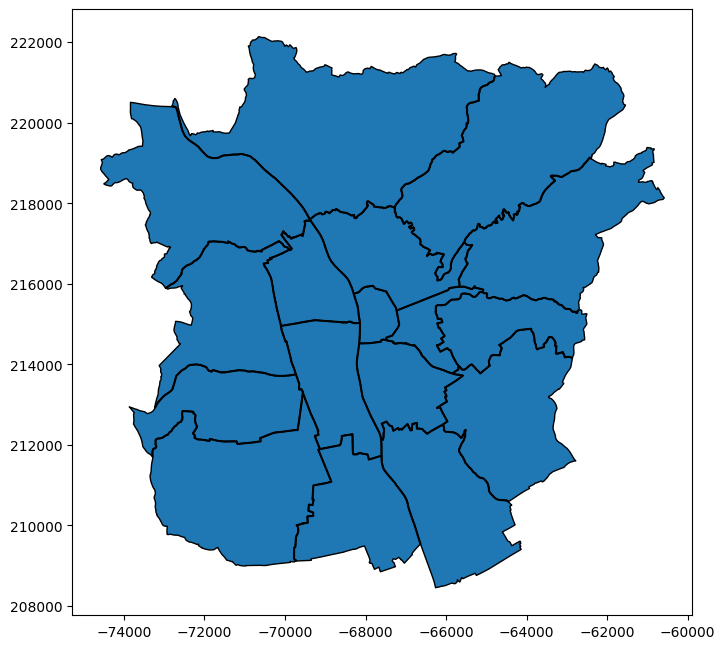

In [9]:
## city and districts
gdf_boundaries = ox.features_from_place(
    place,
    tags={"boundary": "administrative"}
)

df_districts = gdf_boundaries[gdf_boundaries["admin_level"] == "9"]
df_districts = df_districts.to_crs(main_crs)

df_districts.plot(edgecolor="black", figsize=(8, 8))
plt.show()

In [10]:
## main University 
#poi = [
    #"Universitätsplatz 3, 8010 Graz",      
    #"Rechbauerstraße 12, 8010 Graz",      
    #"Neue Stiftingtalstraße 6, 8010 Graz",
    #"Leonhardstraße 15, 8010 Graz",        
    #"Körblergasse 126, 8010 Graz",        
    #"Alte Poststraße 149, 8010 Graz",
    #"Hasnerplatz 12, 8010 Graz",
    #"Inffeldgasse 25, 8010 Graz"   
#]

#coords = [ox.geocode(addr) for addr in poi]
#uni_points = [Point(lon, lat) for lat, lon in coords]

#graz_unis = gpd.GeoDataFrame(
    #{'name': poi},
    #geometry=uni_points,
    #crs="EPSG:4326"
#).to_crs(main_crs)

#graz_unis.plot(figsize=(10,10), color="red", markersize=50, alpha=0.9)
#plt.show()

Invalid district geometries: 0


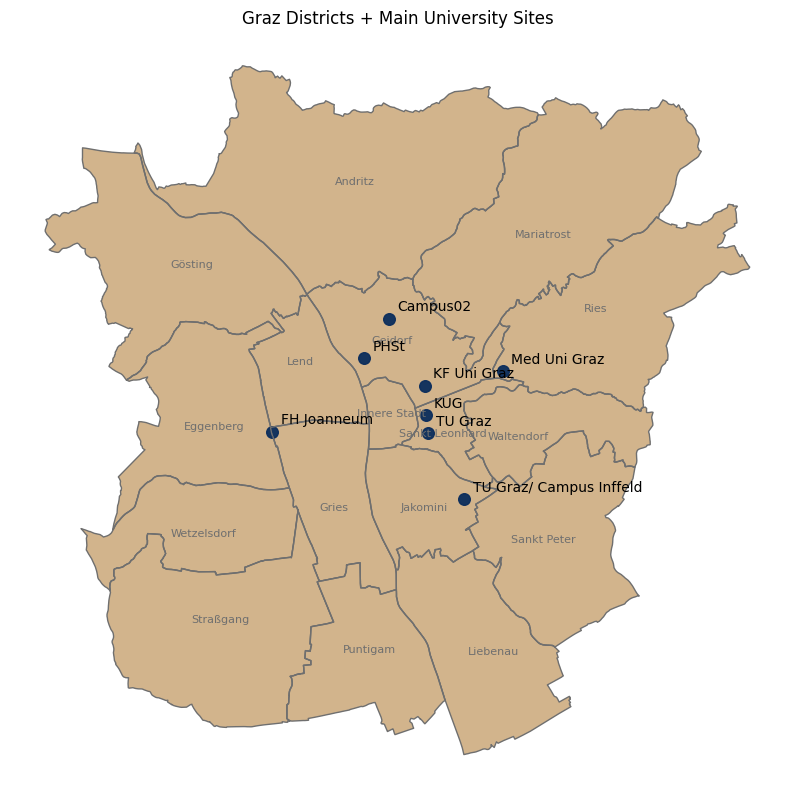

In [11]:
# --- A) University addresses + short labels (mapping) ---
name_map = {
    "Universitätsplatz 3, 8010 Graz": "KF Uni Graz",
    "Rechbauerstraße 12, 8010 Graz": "TU Graz",
    "Neue Stiftingtalstraße 6, 8010 Graz": "Med Uni Graz",
    "Leonhardstraße 15, 8010 Graz": "KUG",
    "Körblergasse 126, 8010 Graz": "Campus02",
    "Alte Poststraße 149, 8010 Graz": "FH Joanneum",
    "Hasnerplatz 12, 8010 Graz": "PHSt",
    "Inffeldgasse 25, 8010 Graz": "TU Graz/ Campus Inffeld",
}

poi = list(name_map.keys())

# Geocode addresses -> (lat, lon) tuples
coords = [ox.geocode(addr) for addr in poi]

# Convert to shapely Points (x=lon, y=lat)
uni_points = [Point(lon, lat) for lat, lon in coords]

# Build a GeoDataFrame in WGS84 and project to your working CRS
graz_unis = gpd.GeoDataFrame(
    {"name": poi},
    geometry=uni_points,
    crs="EPSG:4326"
).to_crs(main_crs)

# Add short labels for plotting
graz_unis["short_name"] = graz_unis["name"].map(name_map).fillna(graz_unis["name"])


# --- B) Prepare districts (project + clean geometry) ---
df_dist = df_districts.to_crs(main_crs).copy()
df_dist = df_dist[df_dist.geometry.notna()].copy()

# Fix invalid geometries (common source of gaps / topology issues)
invalid = ~df_dist.geometry.is_valid
print("Invalid district geometries:", int(invalid.sum()))
if invalid.any():
    try:
        # Shapely 2.x often provides make_valid()
        df_dist.loc[invalid, "geometry"] = df_dist.loc[invalid, "geometry"].make_valid()
    except Exception:
        # Fallback: buffer(0) can fix self-intersections
        df_dist.loc[invalid, "geometry"] = df_dist.loc[invalid, "geometry"].buffer(0)

# Detect the district name column
district_name_col = None
for cand in ["name", "local_name", "district", "District", "bezirk", "BEZIRK"]:
    if cand in df_dist.columns:
        district_name_col = cand
        break

if district_name_col is None:
    raise ValueError(f"No district name column found. Available columns: {list(df_dist.columns)}")

# Normalize district names (helps with St. vs Sankt variants)
def _norm_name(s):
    s = str(s).strip()
    s = s.replace("St.", "Sankt")
    return s

df_dist["name_norm"] = df_dist[district_name_col].apply(_norm_name)

# Keep ONLY the official 17 Graz districts for labeling
graz_district_names = {
    "Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries", "Jakomini",
    "Liebenau", "Sankt Peter", "Waltendorf", "Ries", "Mariatrost",
    "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"
}

df_dist_labels = df_dist[df_dist["name_norm"].isin(graz_district_names)].copy()

# Use representative points for label placement (safer than centroid for complex polygons)
df_dist_labels["label_pt"] = df_dist_labels.geometry.representative_point()


# --- C) Plot districts + labels + universities ---
fig, ax = plt.subplots(figsize=(10, 10))

# District polygons (plot ONCE)
df_dist.plot(
    ax=ax,
    facecolor="#D2B48C",   # tan
    edgecolor="#6f6f6f",   # gray edges
    linewidth=1
)

# District labels
for _, row in df_dist_labels.iterrows():
    x, y = row["label_pt"].x, row["label_pt"].y
    ax.text(
        x, y, row["name_norm"],
        ha="center", va="center",
        fontsize=8, color="#6f6f6f"
    )

# University points
graz_unis.plot(
    ax=ax,
    color="#0B2D5C",   # dark blue
    markersize=70,
    alpha=0.95
)

# University labels
for x, y, lab in zip(graz_unis.geometry.x, graz_unis.geometry.y, graz_unis["short_name"]):
    ax.annotate(
        str(lab),
        (x, y),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        color="black"
    )

ax.set_title("Graz Districts + Main University Sites")
ax.set_axis_off()
plt.show()


In [85]:
# Kepler.gl map (independent from matplotlib plotting)

# If not installed yet:
# pip install keplergl

from keplergl import KeplerGl
import geopandas as gpd

# --- 1) Prepare data for Kepler (Kepler works best in WGS84 / EPSG:4326) ---
# District polygons
districts_k = df_districts.to_crs("EPSG:4326").copy()
districts_k = districts_k[districts_k.geometry.notna()].copy()

# Optional: ensure valid geometries (can help Kepler rendering)
invalid = ~districts_k.geometry.is_valid
if invalid.any():
    try:
        districts_k.loc[invalid, "geometry"] = districts_k.loc[invalid, "geometry"].make_valid()
    except Exception:
        districts_k.loc[invalid, "geometry"] = districts_k.loc[invalid, "geometry"].buffer(0)

# Universities (points)
unis_k = graz_unis.to_crs("EPSG:4326").copy()
unis_k = unis_k[unis_k.geometry.notna()].copy()

# Add lon/lat columns (Kepler can read GeoJSON geometry, but lon/lat columns are handy)
unis_k["lon"] = unis_k.geometry.x
unis_k["lat"] = unis_k.geometry.y

# Optional: keep only relevant columns to reduce payload
# Adjust these if your district name column differs
keep_dist_cols = [c for c in ["name", "local_name", "district", "District", "bezirk", "BEZIRK"] if c in districts_k.columns]
districts_k = districts_k[keep_dist_cols + ["geometry"]] if keep_dist_cols else districts_k[["geometry"]]

keep_uni_cols = [c for c in ["name", "short_name", "lon", "lat"] if c in unis_k.columns]
unis_k = unis_k[keep_uni_cols + ["geometry"]]

# --- 2) Build Kepler map ---
map_ = KeplerGl(height=650)

# Add datasets (names appear in Kepler UI)
map_.add_data(data=districts_k, name="Graz Districts")
map_.add_data(data=unis_k, name="Universities")

map_


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'Graz Districts': {'index': [('relation', 102537), ('relation', 102546), ('relation', 102553), …

In [25]:
from pathlib import Path

# Repo root = one level above "notebooks"
repo_root = Path.cwd().parent

out_dir = repo_root / "outputs" / "kepler"
out_dir.mkdir(parents=True, exist_ok=True)

out_file = out_dir / "kepler_graz_districts_unis.html"
map_.save_to_html(file_name=str(out_file), read_only=False)

print("Saved to:", out_file.resolve())


Map saved to /Users/tarabecker/Uni/GIS_Analyse_Technique2/final-project-group1-cycling-network/outputs/kepler/kepler_graz_districts_unis.html!
Saved to: /Users/tarabecker/Uni/GIS_Analyse_Technique2/final-project-group1-cycling-network/outputs/kepler/kepler_graz_districts_unis.html


## Output Kepler: Website

In [ ]:
#import webbrowser
#webbrowser.open(out_file.resolve().as_uri())


True

## Orignal Network Code

###Variable `G` in the "Road network" block

- Here, `G` is the raw, projected OSMnx bike graph (baseline network).
- Recommended naming for clarity/reproducibility:
  - `G_raw` = download + projection
  - `G_bike` = connector-aware filtered graph
  - `G_core` = largest WCC core (analysis graph)
- Important: snap/route on `G_bike` or `G_core`, not on `G_raw`.


{
  "n": 26264,
  "m": 59037,
  "k_avg": 4.495659457812976,
  "edge_length_total": 3594253.282396802,
  "edge_length_avg": 60.88136731874591,
  "streets_per_node_avg": 2.3776271702710936,
  "streets_per_node_counts": {
    "0": 0,
    "1": 9373,
    "2": 179,
    "3": 14258,
    "4": 2344,
    "5": 97,
    "6": 11,
    "7": 2
  },
  "streets_per_node_proportions": {
    "0": 0.0,
    "1": 0.35687633262260127,
    "2": 0.006815412732257082,
    "3": 0.5428723728297289,
    "4": 0.08924763935424916,
    "5": 0.003693268352116966,
    "6": 0.000418824246116357,
    "7": 7.614986293024673e-05
  },
  "intersection_count": 16891,
  "street_length_total": 1879911.961690623,
  "street_segment_count": 31088,
  "street_length_avg": 60.47066268948222,
  "circuity_avg": 1.0793417342438218,
  "self_loop_proportion": 0.003441842511580031
}


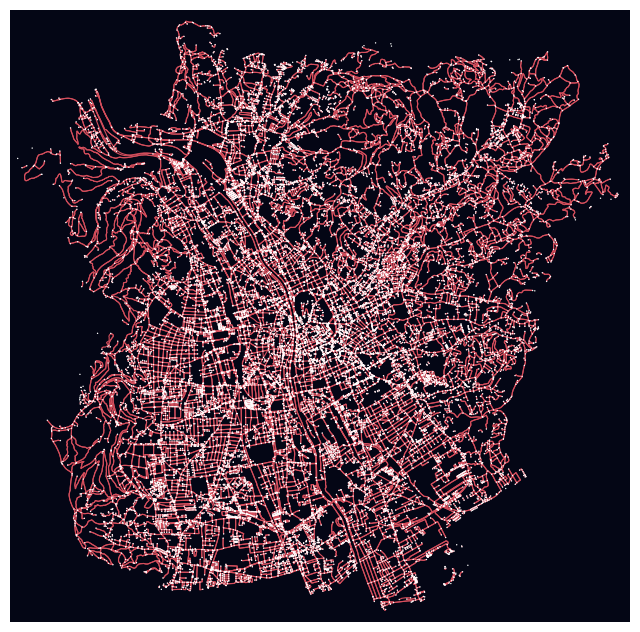

In [30]:
## Road network
G = ox.graph_from_place(
    place,
    network_type="bike",     
    simplify=True,
    retain_all=True           
)

G = ox.project_graph(G, to_crs=main_crs)

G_simple = nx.DiGraph(G)

stats_json = ox.stats.basic_stats(G)
print(json.dumps(stats_json, indent=2))

fig, ax = ox.plot_graph(
    G,
    node_size=1,              
    bgcolor="#040615",
    edge_color="#d44e5c",
    edge_linewidth=0.8
)
plt.show()

## Road network extraction and validation
We extracted a bicycle network for the study area using OSMnx (network_type="bike", simplified topology, retaining all components) and projected it to the working CRS (EPSG:31256). 

To validate the plausibility of the resulting graph, we performed a set of structural and semantic checks:

## First, we assessed network connectivity using strongly connected components (SCCs) on the directed graph. 
The network contains 26,264 nodes and 59,037 edges. The largest SCC includes 24,195 nodes, corresponding to a share of ~0.921 of all nodes. Component size diagnostics further showed a clear “one dominant core” structure (top 10 SCC sizes: [24195, 52, 32, 20, 19, …], total SCC count: 857), indicating that the extracted bike network is largely coherent, while the remaining SCCs are small fragments likely related to boundary effects and minor isolated paths.

## Second, we inspected edge attributes to evaluate whether the extracted “bike” network aligns with realistic cycling infrastructure and routing assumptions. 
The distribution of highway types revealed an unusually large share of service edges (many tagged as service=driveway and service=parking_aisle). These segments represent access roads, parking aisles, and driveway-like connectors that can introduce unrealistic shortcuts and bias routing-based analyses if kept unfiltered.

## Therefore, we did not rely solely on the raw network_type="bike" extraction for routing. 
We used a refined workflow instead of the raw OSMnx bike network. We removed unrealistic `service` segments (e.g., driveways and parking aisles) while keeping the network usable for routing, and we checked both routes and POI integration. Some university locations snapped to small disconnected sub-networks because campus paths in OSM are often mapped as `service`/`path`. To avoid routing failures, we ran the analysis on the largest weakly connected component (the core network) and snapped all POIs to this core (typically within a few tens of meters, up to ~107 m). A final check with a university-to-university route produced plausible results (≈3.18 km from KF Uni Graz to TU Graz Campus Inffeld, ≈12.7 min at 15 km/h), confirming that the final network setup is suitable for accessibility and routing analyses.


In [31]:


# Largest strongly connected component (directed)
largest_scc_nodes = max(nx.strongly_connected_components(G), key=len)
G_scc = G.subgraph(largest_scc_nodes).copy()

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())
print("Largest SCC nodes:", G_scc.number_of_nodes())
print("Share in largest SCC:", G_scc.number_of_nodes() / G.number_of_nodes())


Nodes: 26264 Edges: 59037
Largest SCC nodes: 24195
Share in largest SCC: 0.9212229667986598


In [32]:


# Show the sizes of the largest SCCs to see if the network is mostly one piece
scc_sizes = sorted((len(c) for c in nx.strongly_connected_components(G)), reverse=True)
print("Top 10 SCC sizes:", scc_sizes[:10])
print("Total SCC count:", len(scc_sizes))


Top 10 SCC sizes: [24195, 52, 32, 20, 19, 18, 14, 14, 14, 13]
Total SCC count: 857


The bike graph is structurally consistent and largely connected; detached components are small and have negligible impact on overall network connectivity.

In [33]:


# Convert graph to GeoDataFrames for tag inspection
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Normalize highway field (sometimes it's list-like)
def _hw(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges_gdf["highway_str"] = edges_gdf["highway"].apply(_hw)

# Inspect most common highway types
print(edges_gdf["highway_str"].value_counts().head(25))


highway_str
service                         22451
residential                     14705
path                             6015
cycleway                         3277
secondary                        2943
track                            2494
primary                          2111
tertiary                         1851
unclassified                      998
pedestrian                        549
living_street                     422
path,track                        242
residential,service               224
residential,cycleway              122
service,track                      98
path,service                       86
primary_link                       65
residential,track                  56
service,cycleway                   56
residential,path                   54
residential,pedestrian             32
residential,unclassified           26
pedestrian,service                 14
residential,service,cycleway       14
pedestrian,cycleway                14
Name: count, dtype: int64


“Critically, the attribute distribution indicates that the extracted network includes not only cycleways and streets but is strongly dominated by `service` segments. For analyses intended to approximate realistic bicycle routes, an additional access-/type-based filtering step is therefore advisable.”


In [34]:
# --- Inspect access/bicycle/service subtypes for service edges ---


_, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

def _hw(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges["highway_str"] = edges["highway"].apply(_hw)

service_edges = edges[edges["highway_str"].str.contains("service", na=False)].copy()

cols = [c for c in ["highway_str", "service", "access", "bicycle", "oneway"] if c in service_edges.columns]
print(service_edges[cols].head(20))

# How many are private / driveways (if tags exist)?
if "access" in service_edges.columns:
    print("service edges with access=private:", int((service_edges["access"] == "private").sum()))
if "service" in service_edges.columns:
    print("service edges with service=driveway:", int((service_edges["service"] == "driveway").sum()))


                          highway_str                    service      access  \
u          v          key                                                      
20824622   25045115   0       service                   driveway         NaN   
25045115   1450590151 0       service                   driveway         NaN   
           20824622   0       service                   driveway         NaN   
1829873916 1829873920 0       service                   driveway         NaN   
2207529034 2207529035 0       service                   driveway         NaN   
1450590247 308303503  0       service              parking_aisle         NaN   
8356054384 8356054385 0       service                   driveway         NaN   
1440170206 1440170327 0       service                   driveway         NaN   
4241461916 4241461905 0       service                   driveway   customers   
20825300   2572124714 0       service  [parking_aisle, driveway]         NaN   
2052630918 2052630925 0       service   

## New Try

In [35]:

# --- Convert graph to edges GeoDataFrame for filtering ---
_, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# --- Normalize highway to string for easier filtering ---
def _hw(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges["highway_str"] = edges["highway"].apply(_hw)

# --- Build a boolean mask of edges to DROP (tune to your definition) ---
drop = pd.Series(False, index=edges.index)

# Drop service driveways / parking aisles (very common "shortcuts")
if "service" in edges.columns:
    drop |= (edges["highway_str"].str.contains("service", na=False)) & (
        (edges["service"] == "driveway") |
        (edges["service"] == "parking_aisle")
    )

# Drop explicitly forbidden / private access where tags exist
if "access" in edges.columns:
    drop |= edges["access"].isin(["private", "no"])
if "bicycle" in edges.columns:
    drop |= edges["bicycle"].isin(["no"])

# Optional: drop motorway/trunk types if they appear
drop |= edges["highway_str"].str.contains("motorway|trunk", na=False)

print("Edges before:", len(edges))
print("Edges to drop:", int(drop.sum()))

# --- Rebuild a filtered graph from the kept edges ---
edges_keep = edges.loc[~drop].copy()

# Keep only nodes used by remaining edges
nodes_keep = set(edges_keep.index.get_level_values(0)).union(set(edges_keep.index.get_level_values(1)))
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False).loc[list(nodes_keep)].copy()

G_filt = ox.graph_from_gdfs(nodes, edges_keep)

print("Filtered graph nodes:", G_filt.number_of_nodes(), "edges:", G_filt.number_of_edges())


Edges before: 59037
Edges to drop: 15496
Filtered graph nodes: 19470 edges: 43541


In [36]:
# check again


# Compute SCC share for filtered graph
largest_scc_nodes = max(nx.strongly_connected_components(G_filt), key=len)
Gf_scc = G_filt.subgraph(largest_scc_nodes).copy()

print("Filtered nodes:", G_filt.number_of_nodes(), "Filtered edges:", G_filt.number_of_edges())
print("Largest SCC nodes (filtered):", Gf_scc.number_of_nodes())
print("SCC share (filtered):", Gf_scc.number_of_nodes() / G_filt.number_of_nodes())


Filtered nodes: 19470 Filtered edges: 43541
Largest SCC nodes (filtered): 18030
SCC share (filtered): 0.926040061633282


In [37]:


_, edges_f = ox.graph_to_gdfs(G_filt, nodes=True, edges=True)

def _hw(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges_f["highway_str"] = edges_f["highway"].apply(_hw)
print(edges_f["highway_str"].value_counts().head(20))


highway_str
residential             14688
service                  7498
path                     5939
cycleway                 3259
secondary                2940
track                    2354
primary                  2111
tertiary                 1851
unclassified              989
pedestrian                547
living_street             422
path,track                236
residential,cycleway      122
residential,service        90
primary_link               65
service,track              56
residential,path           52
residential,track          50
service,cycleway           40
path,service               40
Name: count, dtype: int64


Route node count (filtered): 1


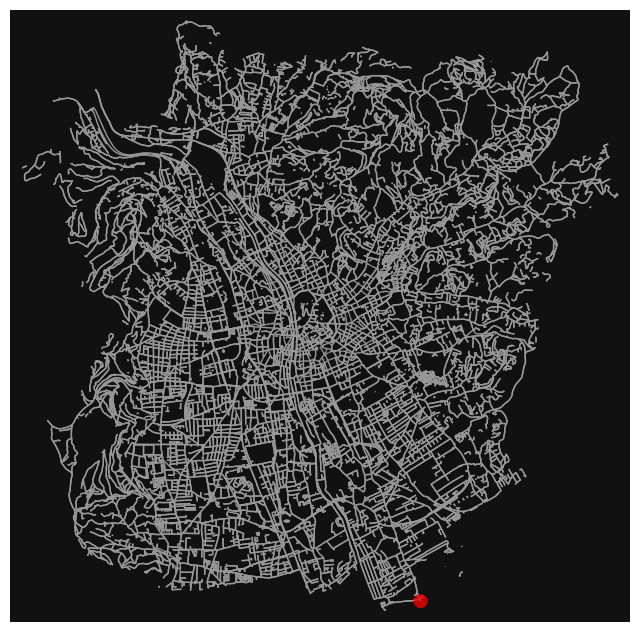

In [38]:

orig = (47.0707, 15.4395)
dest = (47.0830, 15.4510)

o = ox.distance.nearest_nodes(G_filt, orig[1], orig[0])
d = ox.distance.nearest_nodes(G_filt, dest[1], dest[0])

route = nx.shortest_path(G_filt, o, d, weight="length")
print("Route node count (filtered):", len(route))

fig, ax = ox.plot_graph_route(G_filt, route, node_size=0, route_linewidth=3)


In [39]:


orig = (47.0707, 15.4395)  # (lat, lon)
dest = (47.0830, 15.4510)

o = ox.distance.nearest_nodes(G_filt, orig[1], orig[0])
d = ox.distance.nearest_nodes(G_filt, dest[1], dest[0])

print("orig node:", o)
print("dest node:", d)
print("same node?", o == d)


orig node: 4272089864
dest node: 4272089864
same node? True


orig node: 4272089864 dest node: 4272089864 same node? True
Route node count: 1


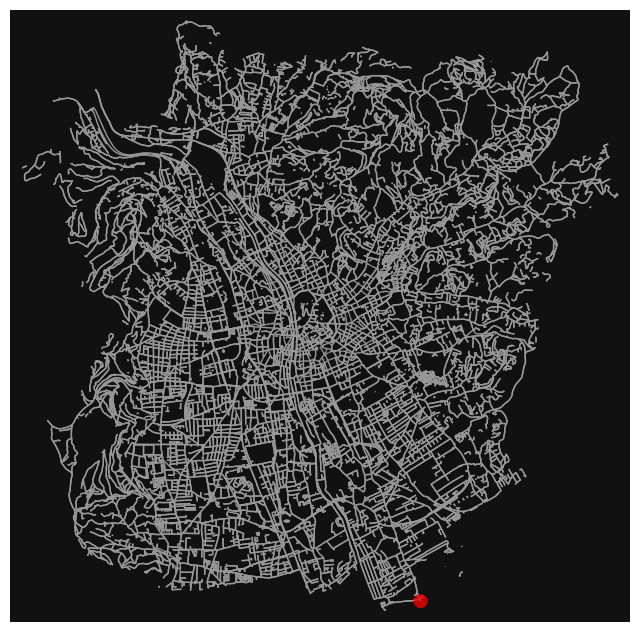

In [44]:


# --- Pick two universities by short_name (or use "name" if you prefer) ---
o_pt = graz_unis.loc[graz_unis["short_name"] == "KF Uni Graz"].to_crs("EPSG:4326").geometry.iloc[0]
d_pt = graz_unis.loc[graz_unis["short_name"] == "TU Graz/ Campus Inffeld"].to_crs("EPSG:4326").geometry.iloc[0]

# --- Map to nearest nodes in the filtered graph ---
o = ox.distance.nearest_nodes(G_filt, o_pt.x, o_pt.y)  # x=lon, y=lat
d = ox.distance.nearest_nodes(G_filt, d_pt.x, d_pt.y)

print("orig node:", o, "dest node:", d, "same node?", o == d)

# --- Compute shortest path ---
route = nx.shortest_path(G_filt, o, d, weight="length")
print("Route node count:", len(route))

# Optional quick plot
fig, ax = ox.plot_graph_route(G_filt, route, node_size=0, route_linewidth=3)


In [45]:
from math import radians, sin, cos, sqrt, atan2

# --- Haversine distance in meters ---
def hav_m(lat1, lon1, lat2, lon2):
    R = 6371000
    p1, p2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dl = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(p1)*cos(p2)*sin(dl/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))

olat, olon = o_pt.y, o_pt.x
dlat, dlon = d_pt.y, d_pt.x

oy, oxn = G_filt.nodes[o]["y"], G_filt.nodes[o]["x"]
dy, dxn = G_filt.nodes[d]["y"], G_filt.nodes[d]["x"]

print("KF Uni → nearest node (m):", round(hav_m(olat, olon, oy, oxn), 1))
print("TU Inffeld → nearest node (m):", round(hav_m(dlat, dlon, dy, dxn), 1))


KF Uni → nearest node (m): 13648940.3
TU Inffeld → nearest node (m): 13648913.7


In [46]:

# --- Check weak connectivity (ignores edge direction) ---
wcc = nx.weakly_connected_components(G_filt)
comp_id = {}
for i, comp in enumerate(wcc):
    for n in comp:
        comp_id[n] = i

print("Same weak component?", comp_id[o] == comp_id[d], " (o:", comp_id[o], " d:", comp_id[d], ")")


Same weak component? True  (o: 0  d: 0 )


### Filterd NETWORK -> G_bike

Code stand alone

In [47]:
# --- 1) Download + projection (raw graph) ---
G_raw = ox.graph_from_place(
    place,
    network_type="bike",
    simplify=True,
    retain_all=True
)
G_raw = ox.project_graph(G_raw, to_crs=main_crs)

# --- 2) Connector-aware filtering (final bike graph) ---
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_raw, nodes=True, edges=True)

def _to_str(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

# Create a string version of highway (can be list-valued in OSM)
edges_gdf["highway_str"] = edges_gdf["highway"].apply(_to_str)

# Flag service edges
is_service = edges_gdf["highway_str"].str.contains("service", na=False)

# Flag driveway/parking_aisle service (service tag can also be list-valued)
is_driveway = pd.Series(False, index=edges_gdf.index)
if "service" in edges_gdf.columns:
    svc_str = edges_gdf["service"].apply(_to_str)
    is_driveway |= svc_str.isin(["driveway", "parking_aisle"])

# Flag forbidden access for bikes
is_forbidden = pd.Series(False, index=edges_gdf.index)
if "access" in edges_gdf.columns:
    is_forbidden |= edges_gdf["access"].isin(["private", "no"])
if "bicycle" in edges_gdf.columns:
    is_forbidden |= edges_gdf["bicycle"].isin(["no"])

service_bad = is_service & (is_driveway | is_forbidden)
non_service = ~is_service

# For each node: does it touch any non-service edge?
touch_non_service = pd.Series(False, index=pd.Index(list(G_raw.nodes), dtype=object))
for (u, v, k), is_ns in non_service.items():
    if is_ns:
        touch_non_service.at[u] = True
        touch_non_service.at[v] = True

# Drop only "bad service" edges that do not connect to any non-service edge at either endpoint
drop = pd.Series(False, index=edges_gdf.index)
for (u, v, k) in edges_gdf.index[service_bad]:
    if (not touch_non_service.get(u, False)) and (not touch_non_service.get(v, False)):
        drop.at[(u, v, k)] = True

print("Edges before:", len(edges_gdf))
print("Edges dropped (connector-aware):", int(drop.sum()))

edges_keep = edges_gdf.loc[~drop].copy()

nodes_keep = set(edges_keep.index.get_level_values(0)).union(
    set(edges_keep.index.get_level_values(1))
)
nodes_keep_gdf = nodes_gdf.loc[list(nodes_keep)].copy()

G_bike = ox.graph_from_gdfs(nodes_keep_gdf, edges_keep)
print("Bike graph nodes:", G_bike.number_of_nodes(), "edges:", G_bike.number_of_edges())


Edges before: 59037
Edges dropped (connector-aware): 6497
Bike graph nodes: 23353 edges: 52540


In [48]:

# --- Projected POIs (same CRS as graph) ---
unis_proj = graz_unis.to_crs(main_crs).copy()

# --- Largest WCC share (connectivity sanity) ---
largest_wcc_nodes = max(nx.weakly_connected_components(G_bike), key=len)
print("WCC share:", len(largest_wcc_nodes) / G_bike.number_of_nodes())

# --- Check if each university snaps into the largest component ---
rows = []
for _, r in unis_proj.iterrows():
    n = ox.distance.nearest_nodes(G_bike, X=r.geometry.x, Y=r.geometry.y)
    rows.append((r["short_name"], n in largest_wcc_nodes))

print(rows)


WCC share: 0.9489573074123239
[('KF Uni Graz', True), ('TU Graz', True), ('Med Uni Graz', True), ('KUG', False), ('Campus02', True), ('FH Joanneum', True), ('PHSt', True), ('TU Graz/ Campus Inffeld', False)]


In [49]:

# --- Component id lookup (weakly connected) ---
comp_id = {}
for i, comp in enumerate(nx.weakly_connected_components(G_bike)):
    for n in comp:
        comp_id[n] = i

unis_proj = graz_unis.to_crs(main_crs).copy()
unis_proj["snap_node"] = unis_proj.geometry.apply(lambda p: ox.distance.nearest_nodes(G_bike, X=p.x, Y=p.y))
unis_proj["comp"] = unis_proj["snap_node"].map(comp_id)

unis_proj[["short_name", "snap_node", "comp"]]


,short_name,snap_node,comp
0,KF Uni Graz,3871900100,0
1,TU Graz,4113732444,0
2,Med Uni Graz,266012637,0
3,KUG,11808409633,54
4,Campus02,1359825555,0
5,FH Joanneum,13384518939,0
6,PHSt,773222019,0
7,TU Graz/ Campus Inffeld,882291834,74


### NEW NETWORK build on core network
-> G_core

In [72]:

# --- Build core network (largest WCC) ---
largest_wcc_nodes = max(nx.weakly_connected_components(G_bike), key=len)
G_core = G_bike.subgraph(largest_wcc_nodes).copy()

print("Core nodes:", G_core.number_of_nodes(), "Core edges:", G_core.number_of_edges())

# --- Snap all unis to the core network (vectorized) ---
unis_proj = graz_unis.to_crs(main_crs).copy()

core_nodes, snap_dists = ox.distance.nearest_nodes(
    G_core,
    X=unis_proj.geometry.x.to_numpy(),
    Y=unis_proj.geometry.y.to_numpy(),
    return_dist=True
)

unis_proj["core_node"] = core_nodes
unis_proj["snap_dist_m"] = snap_dists

# --- Optional: ensure a label column exists for reporting ---
if "short_name" not in unis_proj.columns:
    if "name" in unis_proj.columns:
        unis_proj["short_name"] = unis_proj["name"]
    else:
        unis_proj["short_name"] = unis_proj.index.astype(str)

# --- Report snapping distances (meters) ---
report = unis_proj[["short_name", "core_node", "snap_dist_m"]].sort_values("snap_dist_m", ascending=False)
display(report)
print("Max snap distance (m):", float(unis_proj["snap_dist_m"].max()))
print("Median snap distance (m):", float(unis_proj["snap_dist_m"].median()))



Core nodes: 22161 Core edges: 50883


,short_name,core_node,snap_dist_m
7,TU Graz/ Campus Inffeld,12459216275,106.992237
4,Campus02,1359825555,96.615832
2,Med Uni Graz,266012637,57.639884
0,KF Uni Graz,3871900100,55.232284
3,KUG,1120599503,44.373593
6,PHSt,773222019,44.120209
1,TU Graz,4113732444,28.696822
5,FH Joanneum,13384518939,13.708686


Max snap distance (m): 106.99223735989857
Median snap distance (m): 49.802938451280134


In [74]:
# check: do edges have 'length'?
core_edges = ox.graph_to_gdfs(G_core, nodes=False, edges=True)

if "length" in core_edges.columns:
    print("Missing length share:", float(core_edges["length"].isna().mean()))
else:
    print("No 'length' column on edges.")


Missing length share: 0.0


In [75]:
print("Min length (m):", float(core_edges["length"].min()))
print("Median length (m):", float(core_edges["length"].median()))
print("Max length (m):", float(core_edges["length"].max()))


Min length (m): 0.4853414198157839
Median length (m): 41.222988332701604
Max length (m): 1848.5052991618359


### Conclusion: 
Edge lengths are complete (0% missing). The distribution ranges from sub-meter segments (OSM segmentation near junctions) to ~1.85 km, with a median of ~41 m, indicating a realistic urban network segmentation.

Route node count (core): 67


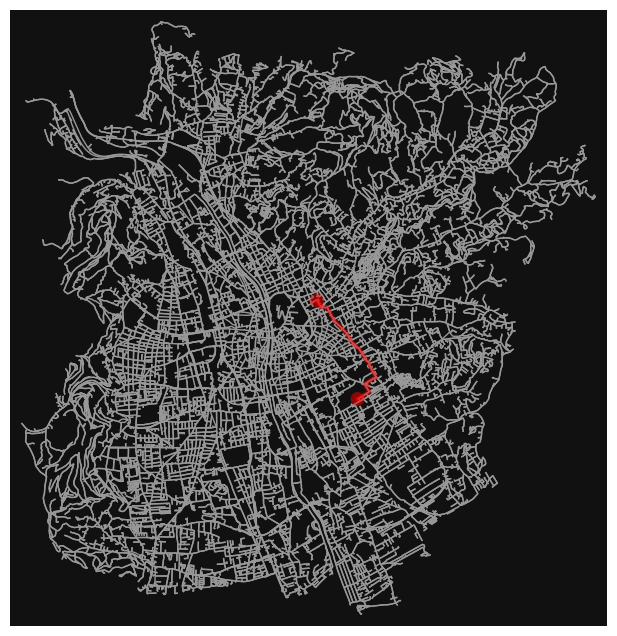

In [70]:

# --- Example: KF Uni -> TU Inffeld using snapped core nodes ---
o = unis_proj.loc[unis_proj["short_name"]=="KF Uni Graz", "core_node"].iloc[0]
d = unis_proj.loc[unis_proj["short_name"]=="TU Graz/ Campus Inffeld", "core_node"].iloc[0]

route = nx.shortest_path(G_core, o, d, weight="length")
print("Route node count (core):", len(route))

# Optional quick plot
import osmnx as ox
fig, ax = ox.plot_graph_route(G_core, route, node_size=0, route_linewidth=3)


In [52]:

# --- Compute total route length (meters) using edge "length" ---
route_len_m = 0.0
for u, v in zip(route[:-1], route[1:]):
    data = G_core.get_edge_data(u, v)

    # MultiDiGraph: pick the edge with minimum length between u and v
    if isinstance(data, dict):
        best = min(data.values(), key=lambda d: d.get("length", float("inf")))
        route_len_m += float(best.get("length", 0.0))
    else:
        # DiGraph case (rare here)
        route_len_m += float(data.get("length", 0.0))

print("Total route length (m):", round(route_len_m, 1))
print("Total route length (km):", round(route_len_m / 1000, 3))


Total route length (m): 3176.8
Total route length (km): 3.177


In [53]:
# --- Estimate travel time given an assumed cycling speed ---
speed_kmh = 15  # change if you want
time_min = (route_len_m / 1000) / speed_kmh * 60
print(f"Estimated time at {speed_kmh} km/h (min):", round(time_min, 1))


Estimated time at 15 km/h (min): 12.7


### Conclusion: 
After connector-aware filtering and restricting analyses to the largest weakly connected component, snapping university POIs to the core network yields valid start/end nodes. A routing sanity check (KF Uni → TU Inffeld) produces a plausible path of ~3.18 km (~12.7 min at 15 km/h), indicating that the processed network is suitable for subsequent route-based analyses.

## Tram network

### Original

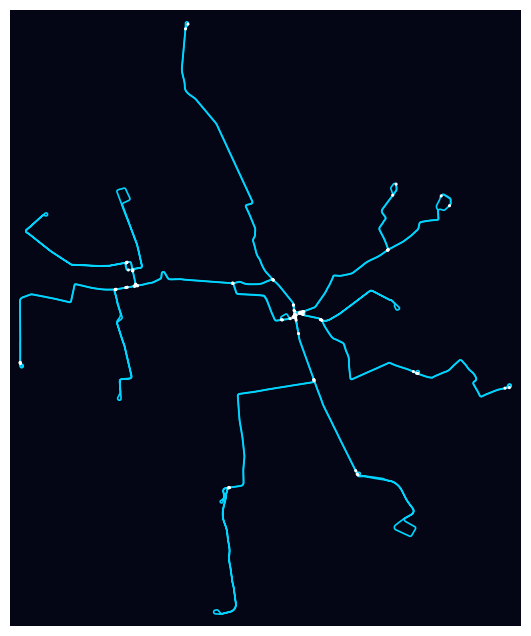

In [65]:
## Tram network
tram = ox.graph_from_place(
    place,
    custom_filter='["railway"="tram"]["service"!="yard"]["service"!="siding"]["service"!="spur"]',
    simplify=True,
    retain_all=True
)

tram = ox.project_graph(tram, to_crs=main_crs)

# to remove isolated edges
comps = list(nx.weakly_connected_components(tram)) 
tram_main = max(comps, key=len) 
tram_main = tram.subgraph(tram_main).copy()

#stats_json = ox.stats.basic_stats(tram_main)
#print(json.dumps(stats_json, indent=2))

fig, ax = ox.plot_graph(
    tram_main,
    node_size=5,
    bgcolor="#040615",
    edge_color="#00d4ff",
    edge_linewidth=1.2
)

### Maybe i need this for Analysis?
Why the function-based version is better?

- Returns `tram_lines` as a GeoDataFrame (ready for GIS analysis).
- Ensures metric `length` (projected CRS).
- Plots lines without noisy graph nodes; cleaner map aesthetic.
- Clear pipeline structure (data step separated from plotting).
- Reproducible export to `outputs/figures/` for the paper.


Tram graph nodes: 107 edges: 178
Tram lines (edges) rows: 178


geometry  \
u          v          key                                                      
300047840  3792704730 0    LINESTRING (-66762.253 212412.641, -66760.409 ...   
                      1    LINESTRING (-66762.253 212412.641, -66762.891 ...   
3792704730 3792609523 0    LINESTRING (-66792.636 212472.001, -66793.802 ...   
1263202258 4295419274 0    LINESTRING (-69097.913 218607.957, -69094.818 ...   
4295419274 3776344475 0    LINESTRING (-67936.436 215099.623, -67937.185 ...   

                                length name  
u          v          key                    
300047840  3792704730 0     128.431255  NaN  
                      1      66.651207  NaN  
3792704730 3792609523 0    1375.223852  NaN  
1263202258 4295419274 0    4041.684793  NaN  
4295419274 3776344475 0     566.295860  NaN

Saved: outputs/figures/tram_lines_neon.png


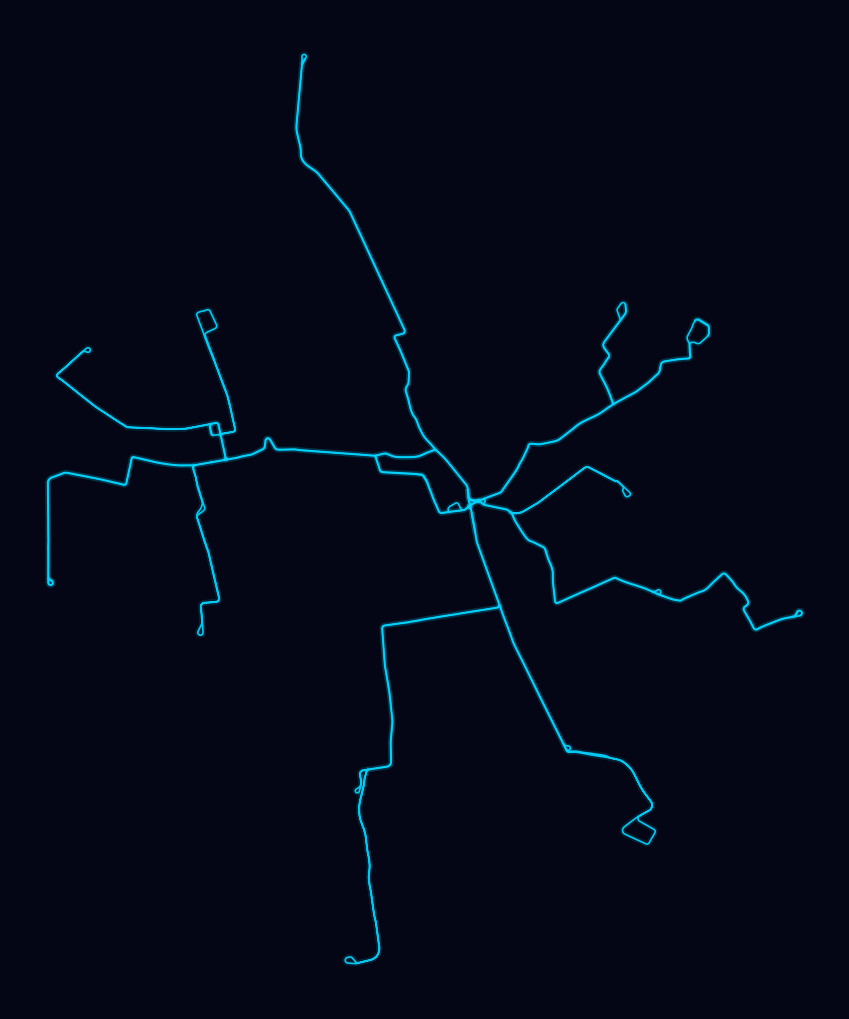

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [ ]:
#with nodes but not shown in the plot



def get_tram_network(place: str, main_crs: str):
    tram_filter = (
        '["railway"="tram"]'
        '["service"!="yard"]'
        '["service"!="siding"]'
        '["service"!="spur"]'
    )

    tram = ox.graph_from_place(
        place,
        custom_filter=tram_filter,
        simplify=True,
        retain_all=True
    )

    tram = ox.project_graph(tram, to_crs=main_crs)

    largest_wcc_nodes = max(nx.weakly_connected_components(tram), key=len)
    tram_main = tram.subgraph(largest_wcc_nodes).copy()

    nodes_gdf, edges_gdf = ox.graph_to_gdfs(tram_main, nodes=True, edges=True)

    if "length" not in edges_gdf.columns:
        edges_gdf["length"] = edges_gdf.geometry.length
    else:
        edges_gdf["length"] = edges_gdf["length"].fillna(edges_gdf.geometry.length)

    keep_cols = ["geometry", "length", "name", "service", "railway"]
    keep_cols = [c for c in keep_cols if c in edges_gdf.columns]
    tram_lines = gpd.GeoDataFrame(edges_gdf[keep_cols].copy(), geometry="geometry", crs=nodes_gdf.crs)

    return tram_main, tram_lines


def plot_tram_lines_neon(
    tram_lines: gpd.GeoDataFrame,
    out_png: str | None = None,
    figsize=(10, 10),
    facecolor="#040615",
    linecolor="#00d4ff",
    glow_width=4.0,
    glow_alpha=0.12,
    core_width=1.2,
    core_alpha=0.95,
    dpi=300
):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)

    tram_lines.plot(ax=ax, linewidth=glow_width, alpha=glow_alpha, color=linecolor)
    tram_lines.plot(ax=ax, linewidth=core_width, alpha=core_alpha, color=linecolor)

    ax.set_axis_off()
    plt.tight_layout(pad=0)

    if out_png:
        os.makedirs(os.path.dirname(out_png), exist_ok=True)
        fig.savefig(out_png, facecolor=facecolor, bbox_inches="tight", pad_inches=0, dpi=dpi)
        print("Saved:", out_png)

    plt.show()
    return fig, ax


# ---- Run ----
place = "Graz, Austria"
main_crs = "EPSG:31256"

tram_main, tram_lines = get_tram_network(place, main_crs)

print("Tram graph nodes:", tram_main.number_of_nodes(), "edges:", tram_main.number_of_edges())
print("Tram lines (edges) rows:", len(tram_lines))
display(tram_lines.head())

plot_tram_lines_neon(tram_lines, out_png="outputs/figures/tram_lines_neon.png")


# Preprocessing

## DEM

In [66]:
# DEM
#path = Path(r"C:\Users\kosch\Desktop\final-project-group1-cycling-network\data_dem")
#FIX_NODATA = -9999.0

#raw_dirs = [path / s for s in ("352x20x","352x21x","353x20x","353x21x","354x20x","354x21x")]

#tiff = sorted({p for d in raw_dirs if d.exists() for p in d.rglob("*.tif")})

#city_geom = df_districts.to_crs(main_crs).dissolve().geometry.iloc[0]

# fixing
#fixed_dir = path / "_fixed_tiles"
#fixed_dir.mkdir(exist_ok=True)

#fixed_tifs = []
#for p in tiff:
#    out_p = fixed_dir / f"{p.parent.name}__{p.name}"
#
#    if not out_p.exists():
#        with rasterio.open(p) as src:
#            data = src.read(1).astype("float32")
#            data[data < -1e20] = FIX_NODATA

#            meta = src.meta.copy()
#            meta.update(dtype="float32", nodata=FIX_NODATA, count=1)

#        with rasterio.open(out_p, "w", **meta) as dst:
#            dst.write(data, 1)

#    fixed_tifs.append(out_p)

# mosaic
#srcs = [rasterio.open(p) for p in fixed_tifs]
#try:
#    mosaic, mosaic_transform = merge(srcs, nodata=FIX_NODATA, dtype="float32")
#    meta = srcs[0].meta.copy()
#finally:
#    for s in srcs:
#        s.close()

#meta.update(
#    height=mosaic.shape[1],
#    width=mosaic.shape[2],
#    transform=mosaic_transform,
#    dtype="float32",
#    nodata=FIX_NODATA,
#    count=mosaic.shape[0],
#)

# crs
#dst_transform, dst_width, dst_height = calculate_default_transform(
#    meta["crs"], main_crs, meta["width"], meta["height"],
#    *rasterio.transform.array_bounds(meta["height"], meta["width"], meta["transform"])
#)

#reproj = np.empty((meta["count"], dst_height, dst_width), dtype="float32")
#for i in range(meta["count"]):
#    reproject(
#        source=mosaic[i],
#        destination=reproj[i],
#        src_transform=meta["transform"],
#        src_crs=meta["crs"],
#        dst_transform=dst_transform,
#        dst_crs=main_crs,
#        resampling=Resampling.bilinear,
#        src_nodata=FIX_NODATA,
#        dst_nodata=FIX_NODATA,
#    )

#reproj_meta = meta.copy()
#reproj_meta.update(crs=main_crs, transform=dst_transform, width=dst_width, height=dst_height)

# clip and save
#with rasterio.io.MemoryFile() as mf:
#    with mf.open(**reproj_meta) as ds:
#        ds.write(reproj)

#        out_img, out_transform = mask(ds, [city_geom], crop=True, nodata=FIX_NODATA)

#        out_meta = ds.meta.copy()
#        out_meta.update(height=out_img.shape[1], width=out_img.shape[2], transform=out_transform, nodata=FIX_NODATA)

#final_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#with rasterio.open(final_path, "w", **out_meta) as dst:
#    dst.write(out_img)



## Slope

In [ ]:
##slope
#dem_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#slope_path = Path("..") / "data" / "processed" / "slope_graz.tif"

#result = subprocess.run([
#        "gdaldem", "slope", str(dem_path), str(slope_path),
#        "-s", "1",                 
#        "-compute_edges",             
#        "-of", "GTiff",               
#        "-co", "COMPRESS=LZW",        
#        "-co", "TILED=YES"           
#    ], 
#    capture_output=True, 
#    text=True, 
#    timeout=300
#    )

## Snapping POI

### Snapping (nearest_nodes/nearest_edges): old vs new network

### What is “compatible”?
- `ox.distance.nearest_nodes/nearest_edges` works with any OSMnx/NetworkX graph.
- It is only compatible if you run it on the **final analysis graph**:
  - e.g. `G_bike` (connector-aware filtered) or `G_core` (largest WCC)

### Why the old results may not carry over
- Filtering can remove edges and disconnect subgraphs.
- Therefore old `nearest_node` matches may:
  - no longer exist in the new graph
  - or shift to different nearest nodes due to topology changes
- `nearest_edge` tuples (u,v,key) are graph-specific → recompute after rebuild/filter.

### What can stay
- The code pattern/method is fine.
- Just replace `G` with `G_bike`/`G_core` and ensure CRS consistency.

### Recommendation
- Snap **after** filtering and (optionally) after extracting the core.
- Add a distance sanity check (e.g., warn if > 200 m).


### Original

In [68]:
## snapping
nodes, node_dists = ox.distance.nearest_nodes(
    G,
    X=graz_unis.geometry.x.to_numpy(),
    Y=graz_unis.geometry.y.to_numpy(),
    return_dist=True
)

graz_unis["nearest_node"] = nodes
graz_unis["dist_to_node_m"] = node_dists

edges, edge_dists = ox.distance.nearest_edges(
    G,
    X=graz_unis.geometry.x.to_numpy(),
    Y=graz_unis.geometry.y.to_numpy(),
    return_dist=True
)

graz_unis["nearest_edge"] = edges
graz_unis["dist_to_edge_m"] = edge_dists

graz_unis_snapped = graz_unis.drop_duplicates(subset=["nearest_node"]).copy()

print(graz_unis[["name", "nearest_node", "dist_to_node_m"]])

                                  name  nearest_node  dist_to_node_m
0       Universitätsplatz 3, 8010 Graz    3871900100       55.232284
1        Rechbauerstraße 12, 8010 Graz    4113732444       28.696822
2  Neue Stiftingtalstraße 6, 8010 Graz     266012637       57.639884
3         Leonhardstraße 15, 8010 Graz   11808409633       42.454915
4          Körblergasse 126, 8010 Graz    1359825555       96.615832
5       Alte Poststraße 149, 8010 Graz   13384518939       13.708686
6            Hasnerplatz 12, 8010 Graz     773222019       44.120209
7           Inffeldgasse 25, 8010 Graz     882291834       71.830795


### Snapping Core network

#nearest_node = core_node
#with short_name

In [87]:
# --- Snapping POIs to core network (used for routing) ---
graz_unis_proj = graz_unis.to_crs(main_crs).copy()

# Ensure short_name exists
if "short_name" not in graz_unis_proj.columns:
    graz_unis_proj["short_name"] = graz_unis_proj["name"]

nodes, node_dists = ox.distance.nearest_nodes(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_node"] = nodes
graz_unis_proj["snap_dist_m"] = node_dists

# optional: edge snapping (only if you later need edge-based metrics)
edges, edge_dists = ox.distance.nearest_edges(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_edge"] = edges
graz_unis_proj["snap_edge_dist_m"] = edge_dists

print(graz_unis_proj[["short_name", "name", "core_node", "snap_dist_m"]].sort_values("snap_dist_m", ascending=False))


                short_name                                 name    core_node  \
7  TU Graz/ Campus Inffeld           Inffeldgasse 25, 8010 Graz  12459216275   
4                 Campus02          Körblergasse 126, 8010 Graz   1359825555   
2             Med Uni Graz  Neue Stiftingtalstraße 6, 8010 Graz    266012637   
0              KF Uni Graz       Universitätsplatz 3, 8010 Graz   3871900100   
3                      KUG         Leonhardstraße 15, 8010 Graz   1120599503   
6                     PHSt            Hasnerplatz 12, 8010 Graz    773222019   
1                  TU Graz        Rechbauerstraße 12, 8010 Graz   4113732444   
5              FH Joanneum       Alte Poststraße 149, 8010 Graz  13384518939   

   snap_dist_m  
7   106.992237  
4    96.615832  
2    57.639884  
0    55.232284  
3    44.373593  
6    44.120209  
1    28.696822  
5    13.708686  


## Pre-comoute distance maps

### Original

### here: 
* **Goal:** compute a single routing “cost” for each edge (lower = preferred).

#67: does it make sense?

* **Base cost = travel time:** `time_cost = length_m / (speed_kmh / 3.6)` (≈ seconds). If speed is missing/invalid → very large fallback cost.
* **High-speed penalty:** if `speed_kmh > 40`, multiply by `1 + ((speed_kmh - 40)/50)^2` → fast roads become less attractive.
* **Tram factor (note!):** if `has_tramway == True`, multiply by **0.8** → makes tram-adjacent edges **more attractive** (this is a *bonus*, not a safety penalty).
* **Slope penalty (weak):** if `slope_pct > 0`, multiply by `1 + (slope_pct/100)^2` → higher slope slightly increases cost; non-positive slope gets no penalty.
* **Final cost:** `time_cost * speed_penalty * tram_factor * slope_penalty`.


In [88]:
# Pre-compute distance maps for both length-based and weighted routing

warnings.filterwarnings('ignore')

print("="*60)
print("SETUP: Pre-computing distance maps for all routing analyses")
print("="*60)

# Filter districts to only valid polygons
valid_districts = []
for idx, district in df_districts.iterrows():
    geom = district.geometry
    if isinstance(geom, Polygon):
        valid_districts.append(district)
    elif isinstance(geom, MultiPolygon):
        valid_districts.append(district)

print(f"\nProcessing {len(valid_districts)} valid district polygons")

# Get all universities
all_uni_node_ids = graz_unis_snapped["nearest_node"].to_list()
print(f"Total universities: {len(all_uni_node_ids)}\n")

# Load slope data
print("Loading slope data...")
slope_path = "/Users/tarabecker/Uni/GIS_Analyse_Technique2/final-project-group1-cycling-network/data/processed/slope_graz.tif"
use_slope = True
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)
    slope_transform = src.transform
    slope_nodata = src.nodata
print(f"  Loaded slope raster: {slope_data.shape}")

# Identify tram edges
print("Identifying tram network edges...")
tram_edges = set()
for u, v in tram_main.edges():
    tram_edges.add((u, v))
    tram_edges.add((v, u))
print(f"  Found {len(tram_edges)} tram edges")

# Speed lookup function
def get_speed_from_edge(edge_data):
    if 'maxspeed' in edge_data:
        try:
            speed_str = edge_data['maxspeed']
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            if 'km/h' in str(speed_str):
                return float(str(speed_str).split()[0])
            else:
                return float(speed_str)
        except:
            pass
    
    highway_type = edge_data.get('highway', 'residential')
    default_speeds = {
        'motorway': 120, 'trunk': 100, 'primary': 80, 'secondary': 60,
        'tertiary': 50, 'residential': 30, 'living_street': 20,
        'pedestrian': 10, 'path': 15, 'cycleway': 25, 'track': 20,
    }
    
    if isinstance(highway_type, list):
        highway_type = highway_type[0]
    return default_speeds.get(highway_type, 50)

# Weighted cost function
def compute_weighted_cost(length_m, speed_kmh, has_tramway, slope_pct):
    time_cost = length_m / (speed_kmh / 3.6) if speed_kmh > 0 else length_m * 100
    speed_penalty = 1.0 + ((speed_kmh - 40) / 50.0) ** 2 if speed_kmh > 40 else 1.0
    tram_factor = 0.8 if has_tramway else 1.0
    slope_penalty = 1.0 + (slope_pct / 100.0) ** 2 if slope_pct > 0 else 1.0
    return time_cost * speed_penalty * tram_factor * slope_penalty

# Add weights to graph edges
print("\nAdding weighted costs to graph edges...")
if use_slope:
    print("  Pre-computing slope interpolator...")
    y_coords = np.arange(slope_data.shape[0])
    x_coords = np.arange(slope_data.shape[1])
    slope_interp = RectBivariateSpline(y_coords, x_coords, slope_data.astype(float))

edge_count = 0
for u, v, data in G_simple.edges(data=True):
    length = data.get('length', 100)
    speed = get_speed_from_edge(data)
    has_tram = (u, v) in tram_edges
    
    if use_slope:
        try:
            x_mid = (G_simple.nodes[u]['x'] + G_simple.nodes[v]['x']) / 2
            y_mid = (G_simple.nodes[u]['y'] + G_simple.nodes[v]['y']) / 2
            row, col = rasterio.transform.rowcol(slope_transform, x_mid, y_mid)
            
            if 0 <= row < slope_data.shape[0] and 0 <= col < slope_data.shape[1]:
                slope = float(slope_interp(row, col)[0][0])
                if np.isnan(slope) or slope == slope_nodata:
                    slope = 0.0
            else:
                slope = 0.0
        except:
            slope = 0.0
    else:
        slope = 0.0
    
    weighted_cost = compute_weighted_cost(length, speed, has_tram, slope)
    
    data['weighted_cost'] = weighted_cost
    data['speed_kmh'] = speed
    data['has_tramway'] = has_tram
    data['slope_pct'] = slope
    edge_count += 1

print(f"  Added weighted costs to {edge_count} edges")

# PRE-COMPUTE SHORTEST PATHS using Dijkstra (SINGLE-SOURCE, REVERSE DIRECTION)
print("\nPre-computing shortest path distances from each university...")
uni_distance_maps = {}

for uni_node in all_uni_node_ids:
    # Length-based Dijkstra (from university to all nodes)
    distances_length = nx.single_source_dijkstra_path_length(
        G_simple, source=uni_node, weight='length'
    )
    paths_length = nx.single_source_dijkstra_path(
        G_simple, source=uni_node, weight='length'
    )
    
    # Weighted cost Dijkstra (from university to all nodes)
    distances_weighted = nx.single_source_dijkstra_path_length(
        G_simple, source=uni_node, weight='weighted_cost'
    )
    paths_weighted = nx.single_source_dijkstra_path(
        G_simple, source=uni_node, weight='weighted_cost'
    )
    
    uni_distance_maps[uni_node] = {
        'distances_length': distances_length,
        'paths_length': paths_length,
        'distances_weighted': distances_weighted,
        'paths_weighted': paths_weighted
    }

print(f"  Pre-computed paths for {len(uni_distance_maps)} universities")

# Define optimized routing function (uses pre-computed paths only)
def find_nearest_uni_fast(node, uni_nodes, uni_distance_maps, weight_type='weighted_cost'):
    best_cost = float('inf')
    best_uni = None
    best_path = None
    
    if weight_type == 'weighted_cost':
        distances_key = 'distances_weighted'
        paths_key = 'paths_weighted'
    else:
        distances_key = f'distances_{weight_type}'
        paths_key = f'paths_{weight_type}'
    
    for uni_node in uni_nodes:
        if node in uni_distance_maps[uni_node][distances_key]:
            cost = uni_distance_maps[uni_node][distances_key][node]
            if cost < best_cost:
                best_cost = cost
                best_uni = uni_node
                best_path = uni_distance_maps[uni_node][paths_key][node]
    
    if best_uni is not None:
        return {
            'uni_node': best_uni,
            'cost': best_cost,
            'path': best_path
        }
    return None

print(f"\n{'='*60}")
print("Setup complete. All Dijkstra pre-computation done.")
print(f"{'='*60}\n")

SETUP: Pre-computing distance maps for all routing analyses

Processing 17 valid district polygons
Total universities: 8

Loading slope data...
  Loaded slope raster: (13668, 13993)
Identifying tram network edges...
  Found 323 tram edges

Adding weighted costs to graph edges...
  Pre-computing slope interpolator...
  Added weighted costs to 58319 edges

Pre-computing shortest path distances from each university...
  Pre-computed paths for 8 universities

Setup complete. All Dijkstra pre-computation done.



### NEW

### Note: Key differences vs. the original pre-computation block

1) **Routing graph and snapped POIs are now consistent**
   - Old: routing/precompute used `G_simple` and university nodes from `graz_unis_snapped["nearest_node"]` (legacy/original setup).
   - New: routing/precompute runs on `G_core` and uses `graz_unis_proj["core_node"]` (snapped to the same core network used for routing).
   - Why it matters: prevents start/end nodes from falling outside the analysis network and avoids “no path” / disconnected issues.

2) **Tram influence is computed spatially (not via node/edge IDs)**
   - Old: `has_tram = (u, v) in tram_edges` where `tram_edges` came from `tram_main`.
   - Problem: tram and bike graphs do not share node IDs → the membership check is almost always false, so tram has virtually no effect.
   - New: tram influence is derived via geometry (distance from each bike edge geometry to `tram_lines`), using a spatial index + a distance threshold.
   - Why it matters: the tram factor actually contributes to `weighted_cost` in a reproducible, GIS-correct way.

3) **Slope sampling is simplified and made more robust**
   - Old: used a spline interpolator (`RectBivariateSpline`), which requires additional setup and can be brittle.
   - New: samples slope from the raster at the edge midpoint using `rasterio.transform.rowcol` (nearest-pixel lookup), with nodata/out-of-bounds handling.
   - Why it matters: fewer dependencies, fewer failure points, and still provides a consistent slope proxy for edge weighting.

Everything else stays conceptually the same:
- edge attributes are enriched (`weighted_cost`, `speed_kmh`, `has_tramway`, `slope_pct`)
- Dijkstra distance/path maps are precomputed per university for both `length` and `weighted_cost`
- a fast lookup function selects the nearest university based on the chosen weight type


### Note: #60: change your path for .tif

In [90]:
# ============================================================
# SETUP: Pre-computing distance maps for routing analyses
# (NEW pipeline: G_core + graz_unis_proj["core_node"] + tram_lines)
# ============================================================

warnings.filterwarnings("ignore")

print("=" * 60)
print("SETUP: Pre-computing distance maps for all routing analyses (NEW)")
print("=" * 60)

# -----------------------------
# 0) Basic checks
# -----------------------------
if "core_node" not in graz_unis_proj.columns:
    raise ValueError("graz_unis_proj must contain column 'core_node' (snapped node ids on G_core).")

if tram_lines.crs is None:
    raise ValueError("tram_lines has no CRS. Ensure tram_lines is projected to main_crs.")
if str(tram_lines.crs) != str(main_crs):
    # keep it safe: force to main_crs
    tram_lines = tram_lines.to_crs(main_crs)

# Make sure edge length exists (OSMnx usually provides it)
# If something is missing, backfill from geometry.
edges_tmp = ox.graph_to_gdfs(G_core, nodes=False, edges=True)
if "length" not in edges_tmp.columns:
    print("No 'length' attribute found on edges -> computing from geometry length.")
    for u, v, k, data in G_core.edges(keys=True, data=True):
        geom = data.get("geometry", None)
        if geom is None:
            # build a straight line if geometry missing
            x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
            x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
            geom = LineString([(x1, y1), (x2, y2)])
            data["geometry"] = geom
        data["length"] = float(geom.length)

# -----------------------------
# 1) District polygons (optional in later steps)
# -----------------------------
valid_districts = []
for _, district in df_districts.iterrows():
    geom = district.geometry
    if isinstance(geom, Polygon) or isinstance(geom, MultiPolygon):
        valid_districts.append(district)

print(f"\nProcessing {len(valid_districts)} valid district polygons")

# -----------------------------
# 2) University nodes (NEW)
# -----------------------------
all_uni_node_ids = graz_unis_proj["core_node"].tolist()
print(f"Total universities (snapped): {len(all_uni_node_ids)}\n")

# -----------------------------
# 3) Load slope raster (hard path stays)
# -----------------------------
print("Loading slope data...")
slope_path = "/Users/tarabecker/Uni/GIS_Analyse_Technique2/final-project-group1-cycling-network/data/processed/slope_graz.tif"
use_slope = True

with rasterio.open(slope_path) as src:
    slope_data = src.read(1)
    slope_transform = src.transform
    slope_nodata = src.nodata

print(f"  Loaded slope raster: {slope_data.shape}, nodata={slope_nodata}")

# Helper: sample slope at (x,y) in graph CRS using nearest pixel
def sample_slope_pct(x, y):
    try:
        row, col = rasterio.transform.rowcol(slope_transform, x, y)
        if 0 <= row < slope_data.shape[0] and 0 <= col < slope_data.shape[1]:
            val = float(slope_data[row, col])
            if (slope_nodata is not None and val == slope_nodata) or np.isnan(val):
                return 0.0
            return val
        return 0.0
    except Exception:
        return 0.0

# -----------------------------
# 4) Tram proximity (NEW, spatial)
# -----------------------------
print("Preparing tram spatial index...")
tram_sindex = tram_lines.sindex

# threshold: when an edge is considered "tram-influenced"
TRAM_DIST_M = 15.0  # tune (e.g. 10–25m)

def edge_tram_distance_m(edge_geom):
    """
    Returns min distance (m) from edge geometry to nearest tram line.
    Uses spatial index for candidates, then exact distance.
    """
    if edge_geom is None:
        return float("inf")

    # quick bbox query (expand bbox by TRAM_DIST_M)
    minx, miny, maxx, maxy = edge_geom.bounds
    bbox = (minx - TRAM_DIST_M, miny - TRAM_DIST_M, maxx + TRAM_DIST_M, maxy + TRAM_DIST_M)

    cand_idx = list(tram_sindex.intersection(bbox))
    if not cand_idx:
        return float("inf")

    cands = tram_lines.geometry.iloc[cand_idx]
    # exact min distance
    return float(cands.distance(edge_geom).min())

print("Tram index ready.")

# -----------------------------
# 5) Speed lookup + weighted cost (same idea, but on G_core)
# -----------------------------
def get_speed_from_edge(edge_data):
    if "maxspeed" in edge_data:
        try:
            speed_str = edge_data["maxspeed"]
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            s = str(speed_str)
            if "km/h" in s:
                return float(s.split()[0])
            return float(s)
        except Exception:
            pass

    highway_type = edge_data.get("highway", "residential")
    if isinstance(highway_type, list):
        highway_type = highway_type[0]

    default_speeds = {
        "motorway": 120, "trunk": 100, "primary": 80, "secondary": 60,
        "tertiary": 50, "residential": 30, "living_street": 20,
        "pedestrian": 10, "path": 15, "cycleway": 25, "track": 20,
    }
    return float(default_speeds.get(highway_type, 30))

def compute_weighted_cost(length_m, speed_kmh, has_tramway, slope_pct):
    time_cost = length_m / (speed_kmh / 3.6) if speed_kmh > 0 else length_m * 100.0

    speed_penalty = 1.0 + ((speed_kmh - 40.0) / 50.0) ** 2 if speed_kmh > 40.0 else 1.0

    # Tram near the route is treated as a risk -> penalty (> 1)
    tram_factor = 1.2 if has_tramway else 1.0

    # Steepness (up or down) is treated as unpleasant -> use absolute value
    slope_penalty = 1.0 + (abs(slope_pct) / 100.0) ** 2

    return float(time_cost * speed_penalty * tram_factor * slope_penalty)


# -----------------------------
# 6) Add weights to ALL edges in G_core (MultiDiGraph safe)
# -----------------------------
print("\nAdding weighted costs to G_core edges...")

edge_count = 0
tram_true = 0

for u, v, k, data in G_core.edges(keys=True, data=True):
    length_m = float(data.get("length", 100.0))

    # geometry for tram distance + slope sampling
    geom = data.get("geometry", None)
    if geom is None:
        x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
        x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
        geom = LineString([(x1, y1), (x2, y2)])
        data["geometry"] = geom

    # speed
    speed_kmh = get_speed_from_edge(data)

    # slope at midpoint
    if use_slope:
        mx, my = geom.interpolate(0.5, normalized=True).x, geom.interpolate(0.5, normalized=True).y
        slope_pct = sample_slope_pct(mx, my)
    else:
        slope_pct = 0.0

    # tram proximity
    tram_dist = edge_tram_distance_m(geom)
    has_tram = tram_dist <= TRAM_DIST_M
    if has_tram:
        tram_true += 1

    # weighted cost
    weighted_cost = compute_weighted_cost(length_m, speed_kmh, has_tram, slope_pct)

    # store attributes
    data["weighted_cost"] = float(weighted_cost)
    data["speed_kmh"] = float(speed_kmh)
    data["has_tramway"] = bool(has_tram)
    data["tram_dist_m"] = float(tram_dist if np.isfinite(tram_dist) else 999999.0)
    data["slope_pct"] = float(slope_pct)

    edge_count += 1

print(f"  Added weighted costs to {edge_count} edges")
print(f"  Edges flagged near tram (<= {TRAM_DIST_M} m): {tram_true} ({tram_true/edge_count:.2%})")

# -----------------------------
# 7) Pre-compute Dijkstra maps for each university
# -----------------------------
print("\nPre-computing shortest-path distances from each university...")
uni_distance_maps = {}

# For speed: if you want, you can run only subset first
for uni_node in all_uni_node_ids:
    # length-based
    distances_length = nx.single_source_dijkstra_path_length(
        G_core, source=uni_node, weight="length"
    )
    paths_length = nx.single_source_dijkstra_path(
        G_core, source=uni_node, weight="length"
    )

    # weighted-cost
    distances_weighted = nx.single_source_dijkstra_path_length(
        G_core, source=uni_node, weight="weighted_cost"
    )
    paths_weighted = nx.single_source_dijkstra_path(
        G_core, source=uni_node, weight="weighted_cost"
    )

    uni_distance_maps[uni_node] = {
        "distances_length": distances_length,
        "paths_length": paths_length,
        "distances_weighted": distances_weighted,
        "paths_weighted": paths_weighted,
    }

print(f"  Pre-computed paths for {len(uni_distance_maps)} universities")

# -----------------------------
# 8) Fast lookup using precomputed maps
# -----------------------------
def find_nearest_uni_fast(node, uni_nodes, uni_distance_maps, weight_type="weighted_cost"):
    best_cost = float("inf")
    best_uni = None
    best_path = None

    if weight_type == "weighted_cost":
        distances_key = "distances_weighted"
        paths_key = "paths_weighted"
    elif weight_type == "length":
        distances_key = "distances_length"
        paths_key = "paths_length"
    else:
        raise ValueError("weight_type must be 'length' or 'weighted_cost'")

    for uni_node in uni_nodes:
        dist_map = uni_distance_maps[uni_node][distances_key]
        if node in dist_map:
            cost = dist_map[node]
            if cost < best_cost:
                best_cost = cost
                best_uni = uni_node
                best_path = uni_distance_maps[uni_node][paths_key][node]

    if best_uni is not None:
        return {"uni_node": best_uni, "cost": best_cost, "path": best_path}
    return None

print(f"\n{'='*60}")
print("Setup complete. Dijkstra pre-computation done (NEW).")
print(f"{'='*60}\n")


SETUP: Pre-computing distance maps for all routing analyses (NEW)

Processing 17 valid district polygons
Total universities (snapped): 8

Loading slope data...
  Loaded slope raster: (13668, 13993), nodata=-9999.0
Preparing tram spatial index...
Tram index ready.

Adding weighted costs to G_core edges...
  Added weighted costs to 50883 edges
  Edges flagged near tram (<= 15.0 m): 3588 (7.05%)

Pre-computing shortest-path distances from each university...
  Pre-computed paths for 8 universities

Setup complete. Dijkstra pre-computation done (NEW).



# ANALYSIS

### Original

GRID-BASED ROUTING ANALYSIS (300m grid)
Created 2162 grid cells of 300m × 300m

Mapping nodes to grid cells...
Assigned 26264 nodes to grid cells

Routing nodes to nearest university (length-based)...
Processed 1393 grid cells with nodes

Grid cells with routing data: 1393

Creating grid visualization...


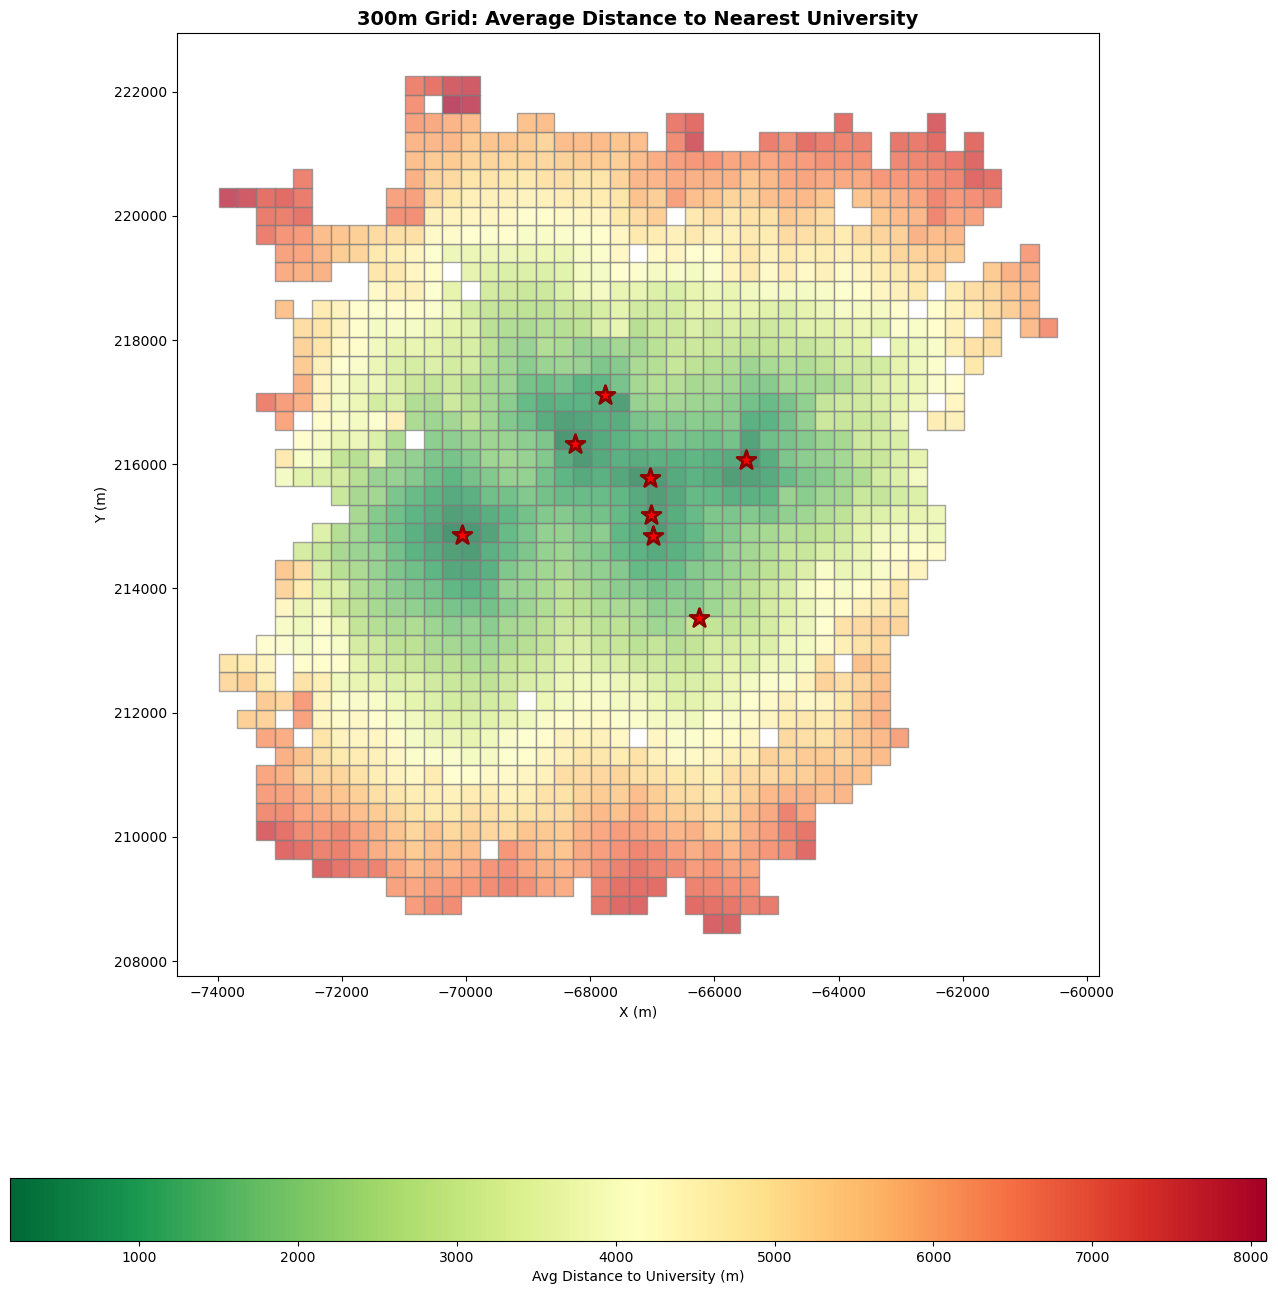

Grid analysis complete.



In [21]:
# GRID ANALYSIS: 300m grid routing (OPTIMIZED with pre-computed paths)
print("="*60)
print("GRID-BASED ROUTING ANALYSIS (300m grid)")
print("="*60)

# Create 300m grid over Graz
from shapely.geometry import box
import numpy as np

city_bounds = df_districts.geometry.total_bounds  # (minx, miny, maxx, maxy)
grid_size = 300  # 300 meters

# Generate grid cells
grid_cells = []
cell_id = 0
x = city_bounds[0]
while x < city_bounds[2]:
    y = city_bounds[1]
    while y < city_bounds[3]:
        grid_cells.append({
            'cell_id': cell_id,
            'geometry': box(x, y, x + grid_size, y + grid_size)
        })
        cell_id += 1
        y += grid_size
    x += grid_size

gdf_grid = gpd.GeoDataFrame(grid_cells, crs=main_crs)
print(f"Created {len(gdf_grid)} grid cells of {grid_size}m × {grid_size}m")

# Spatial join: find nodes in each grid cell 
print("\nMapping nodes to grid cells...")
nodes_gdf = gpd.GeoDataFrame(
    geometry=[Point(data['x'], data['y']) for node, data in G_simple.nodes(data=True)],
    crs=main_crs
)
nodes_gdf['node_id'] = list(G_simple.nodes())

# Spatial join 
node_grid_join = gpd.sjoin(nodes_gdf, gdf_grid, how='inner', predicate='within')
print(f"Assigned {len(node_grid_join)} nodes to grid cells")

# Route all nodes to nearest university
print("\nRouting nodes to nearest university (length-based)...")
grid_results = {}

for cell_id in gdf_grid['cell_id'].unique():
    nodes_in_cell = node_grid_join[node_grid_join['cell_id'] == cell_id]['node_id'].tolist()
    
    if len(nodes_in_cell) == 0:
        continue
    
    distances = []
    for origin_node in nodes_in_cell:
        result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='length')
        if result:
            distances.append(result['cost'])
    
    if distances:
        grid_results[cell_id] = {
            'num_nodes': len(nodes_in_cell),
            'avg_distance_m': np.mean(distances),
            'min_distance_m': np.min(distances),
            'max_distance_m': np.max(distances),
        }

print(f"Processed {len(grid_results)} grid cells with nodes")

# Add grid results to GeoDataFrame
gdf_grid['avg_distance'] = gdf_grid['cell_id'].map(
    lambda x: grid_results.get(x, {}).get('avg_distance_m', 0)
)
gdf_grid_with_data = gdf_grid[gdf_grid['avg_distance'] > 0]

print(f"\n{'='*60}")
print(f"Grid cells with routing data: {len(gdf_grid_with_data)}")
print(f"{'='*60}\n")

# Visualization: Grid with distance gradient
print("Creating grid visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_with_data.plot(
    ax=ax,
    column='avg_distance',
    cmap='RdYlGn_r',
    edgecolor='gray',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Distance to University (m)', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('300m Grid: Average Distance to Nearest University', fontsize=14, fontweight='bold')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.show()

print("Grid analysis complete.\n")


WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid)
Routing nodes to nearest university (weighted cost)...
Processed 1393 grid cells with nodes (weighted)

Grid cells with weighted routing data: 1393

Creating weighted grid visualization...


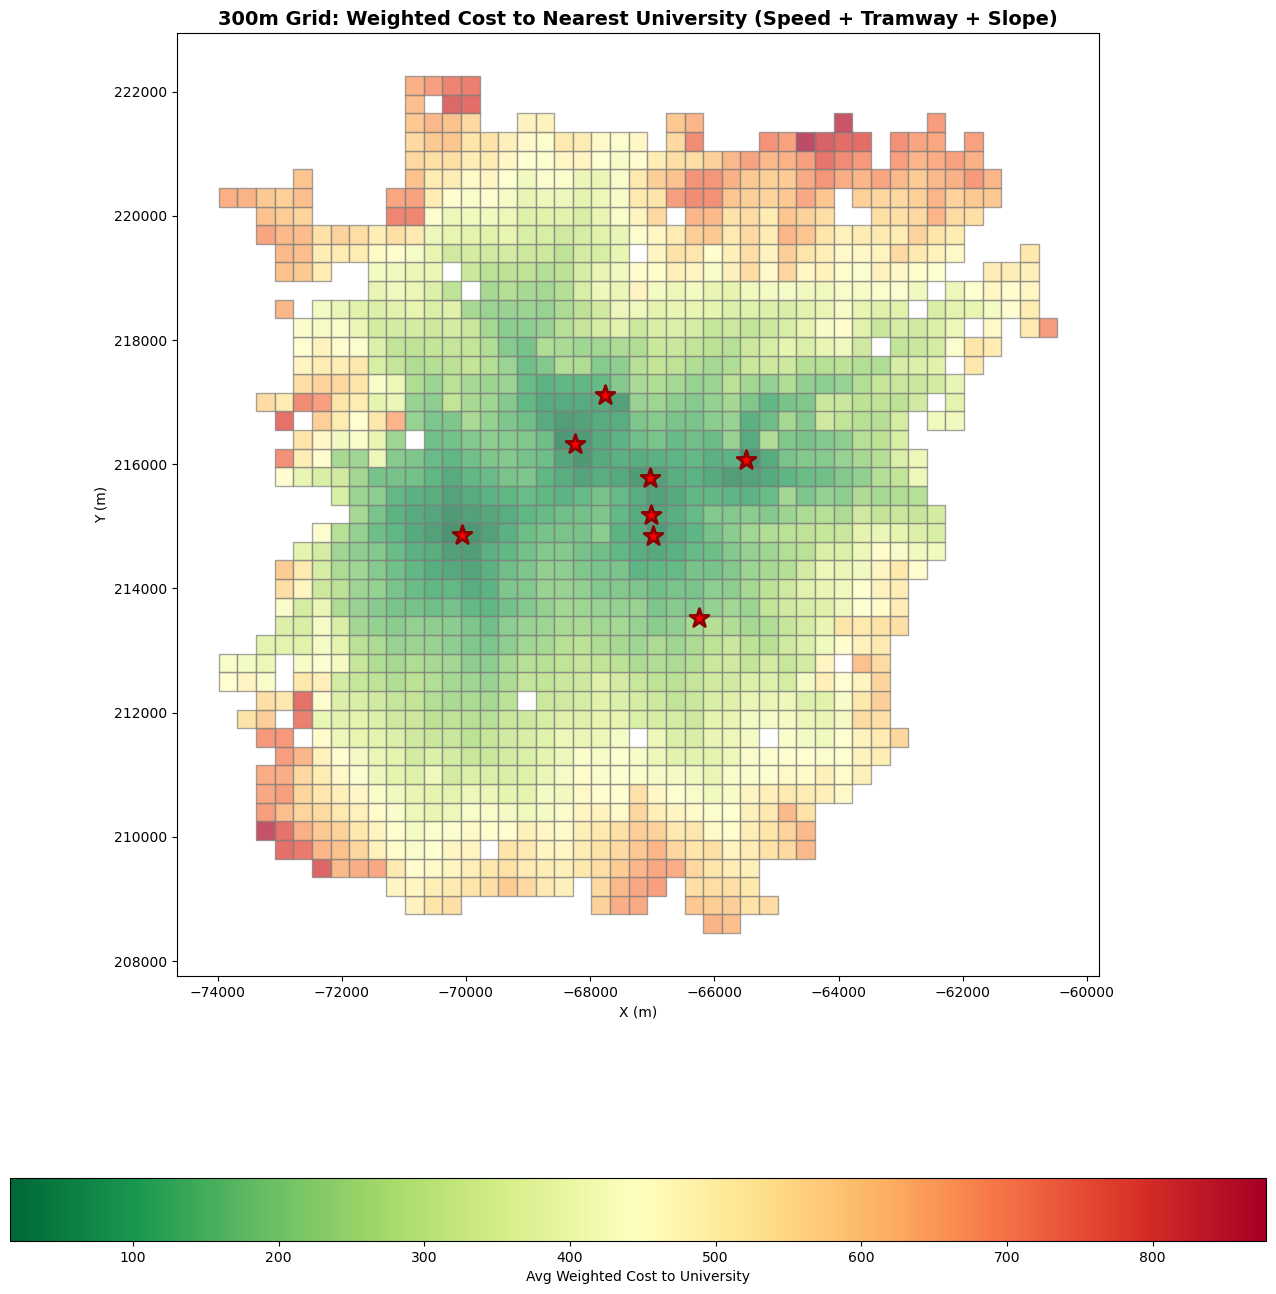


Weighted grid analysis complete.



In [22]:
# WEIGHTED GRID ANALYSIS: 300m grid with weighted routing (speed, tramway, slope)
print("="*60)
print("WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid)")
print("="*60)

# Route all nodes to nearest university using weighted cost
print("Routing nodes to nearest university (weighted cost)...")
grid_results_weighted = {}

for cell_id in gdf_grid['cell_id'].unique():
    nodes_in_cell = node_grid_join[node_grid_join['cell_id'] == cell_id]['node_id'].tolist()
    
    if len(nodes_in_cell) == 0:
        continue
    
    costs = []
    for origin_node in nodes_in_cell:
        result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='weighted_cost')
        if result:
            costs.append(result['cost'])
    
    if costs:
        grid_results_weighted[cell_id] = {
            'num_nodes': len(nodes_in_cell),
            'avg_weighted_cost': np.mean(costs),
            'min_weighted_cost': np.min(costs),
            'max_weighted_cost': np.max(costs),
        }

print(f"Processed {len(grid_results_weighted)} grid cells with nodes (weighted)")

# Add weighted results to GeoDataFrame
gdf_grid['avg_weighted_cost'] = gdf_grid['cell_id'].map(
    lambda x: grid_results_weighted.get(x, {}).get('avg_weighted_cost', 0)
)
gdf_grid_weighted_with_data = gdf_grid[gdf_grid['avg_weighted_cost'] > 0]

print(f"\n{'='*60}")
print(f"Grid cells with weighted routing data: {len(gdf_grid_weighted_with_data)}")
print(f"{'='*60}\n")

# Visualization: Weighted grid with cost gradient
print("Creating weighted grid visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_weighted_with_data.plot(
    ax=ax,
    column='avg_weighted_cost',
    cmap='RdYlGn_r',
    edgecolor='gray',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Weighted Cost to University', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('300m Grid: Weighted Cost to Nearest University (Speed + Tramway + Slope)', fontsize=14, fontweight='bold')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.show()

print("\nWeighted grid analysis complete.\n")


In [23]:
# LENGTH-BASED ROUTING: Districts using pre-computed distance maps 
print("="*60)
print("LENGTH-BASED ROUTING ANALYSIS FOR DISTRICTS")
print("="*60)

district_results = {}

for district in valid_districts:
    district_name = district["name"]
    print(f"Routing for district: {district_name}")

    try:
        district_geom = district.geometry

        G_district = ox.truncate.truncate_graph_polygon(
            G_simple,
            district_geom,
            truncate_by_edge=True
        )

        nodes_in_district = list(G_district.nodes)
        
        if len(nodes_in_district) == 0:
            print(f"  No nodes in district '{district_name}', skipping")
            continue

        print(f"  {len(nodes_in_district)} nodes in district")

        # Use pre-computed paths (no network calls needed)
        routes_data = []
        distances = []

        for origin_node in nodes_in_district:
            # Use pre-computed length-based paths 
            result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='length')
            
            if result:
                routes_data.append({
                    'origin_node': origin_node,
                    'uni_node': result['uni_node'],
                    'distance_m': result['cost'],
                    'district': district_name,
                    'path': result['path']
                })
                distances.append(result['cost'])

        if distances:
            print(f"  Successfully routed {len(routes_data)}/{len(nodes_in_district)} nodes (length-based)")
            district_results[district_name] = {
                'total_routes': len(routes_data),
                'avg_distance_m': np.mean(distances),
                'min_distance_m': np.min(distances),
                'max_distance_m': np.max(distances),
                'routes': routes_data
            }
    
    except Exception as e:
        print(f"  Error processing district '{district_name}': {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"Total districts processed (length-based): {len(district_results)}")
print(f"{'='*60}\n")


LENGTH-BASED ROUTING ANALYSIS FOR DISTRICTS
Routing for district: Innere Stadt
  762 nodes in district
  Successfully routed 616/762 nodes (length-based)
Routing for district: Liebenau
  1507 nodes in district
  Successfully routed 1349/1507 nodes (length-based)
Routing for district: Sankt Leonhard
  1047 nodes in district
  Successfully routed 1005/1047 nodes (length-based)
Routing for district: Geidorf
  1866 nodes in district
  Successfully routed 1783/1866 nodes (length-based)
Routing for district: Lend
  1404 nodes in district
  Successfully routed 1352/1404 nodes (length-based)
Routing for district: Gries
  1762 nodes in district
  Successfully routed 1596/1762 nodes (length-based)
Routing for district: Jakomini
  1472 nodes in district
  Successfully routed 1431/1472 nodes (length-based)
Routing for district: Sankt Peter
  1738 nodes in district
  Successfully routed 1605/1738 nodes (length-based)
Routing for district: Waltendorf
  1094 nodes in district
  Successfully routed 98

In [24]:
# Create summary dataframe
summary_df = pd.DataFrame([
    {
        'District': district_name,
        'Total Routes': stats['total_routes'],
        'Avg Distance (m)': stats['avg_distance_m'],
        'Min Distance (m)': stats['min_distance_m'],
        'Max Distance (m)': stats['max_distance_m'],
    }
    for district_name, stats in district_results.items()
])

print("\nDistrict Summary:")
print(summary_df.to_string())

# summary_df.to_csv("district_routes_summary.csv", index=False)


District Summary:
          District  Total Routes  Avg Distance (m)  Min Distance (m)  Max Distance (m)
0     Innere Stadt           616       1174.467978        416.137102       2087.043828
1         Liebenau          1349       4955.258790       2890.167236       7699.265482
2   Sankt Leonhard          1005        947.302361          0.000000       2359.539995
3          Geidorf          1783       1038.026538          0.000000       2494.548865
4             Lend          1352       1414.774144         96.991960       2928.798827
5            Gries          1596       2303.833405          0.000000       4529.384555
6         Jakomini          1431       2071.313479          0.000000       3951.947984
7      Sankt Peter          1605       4202.363007       2069.919387       6690.080107
8       Waltendorf           987       2380.818441        316.771737       4849.831060
9             Ries           940       2595.979427          0.000000       6665.767872
10      Mariatrost      

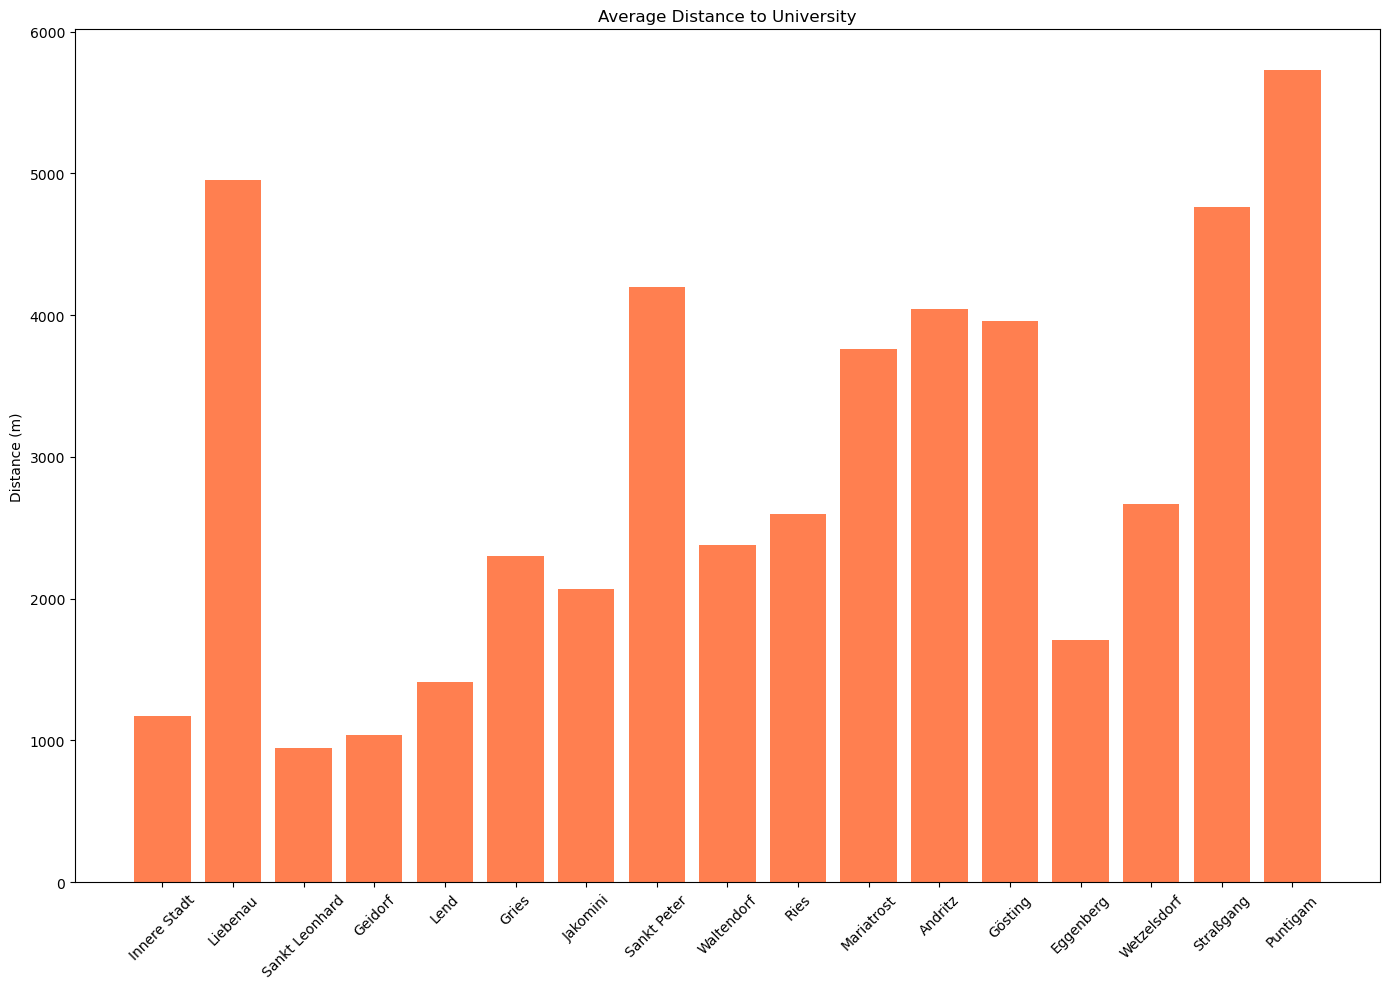

In [25]:
# Visualization 1: Bar charts for district statistics
fig, axes = plt.subplots(figsize=(14, 10))

plt.bar(summary_df['District'], summary_df['Avg Distance (m)'], color='coral')
plt.title('Average Distance to University')
plt.ylabel('Distance (m)')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

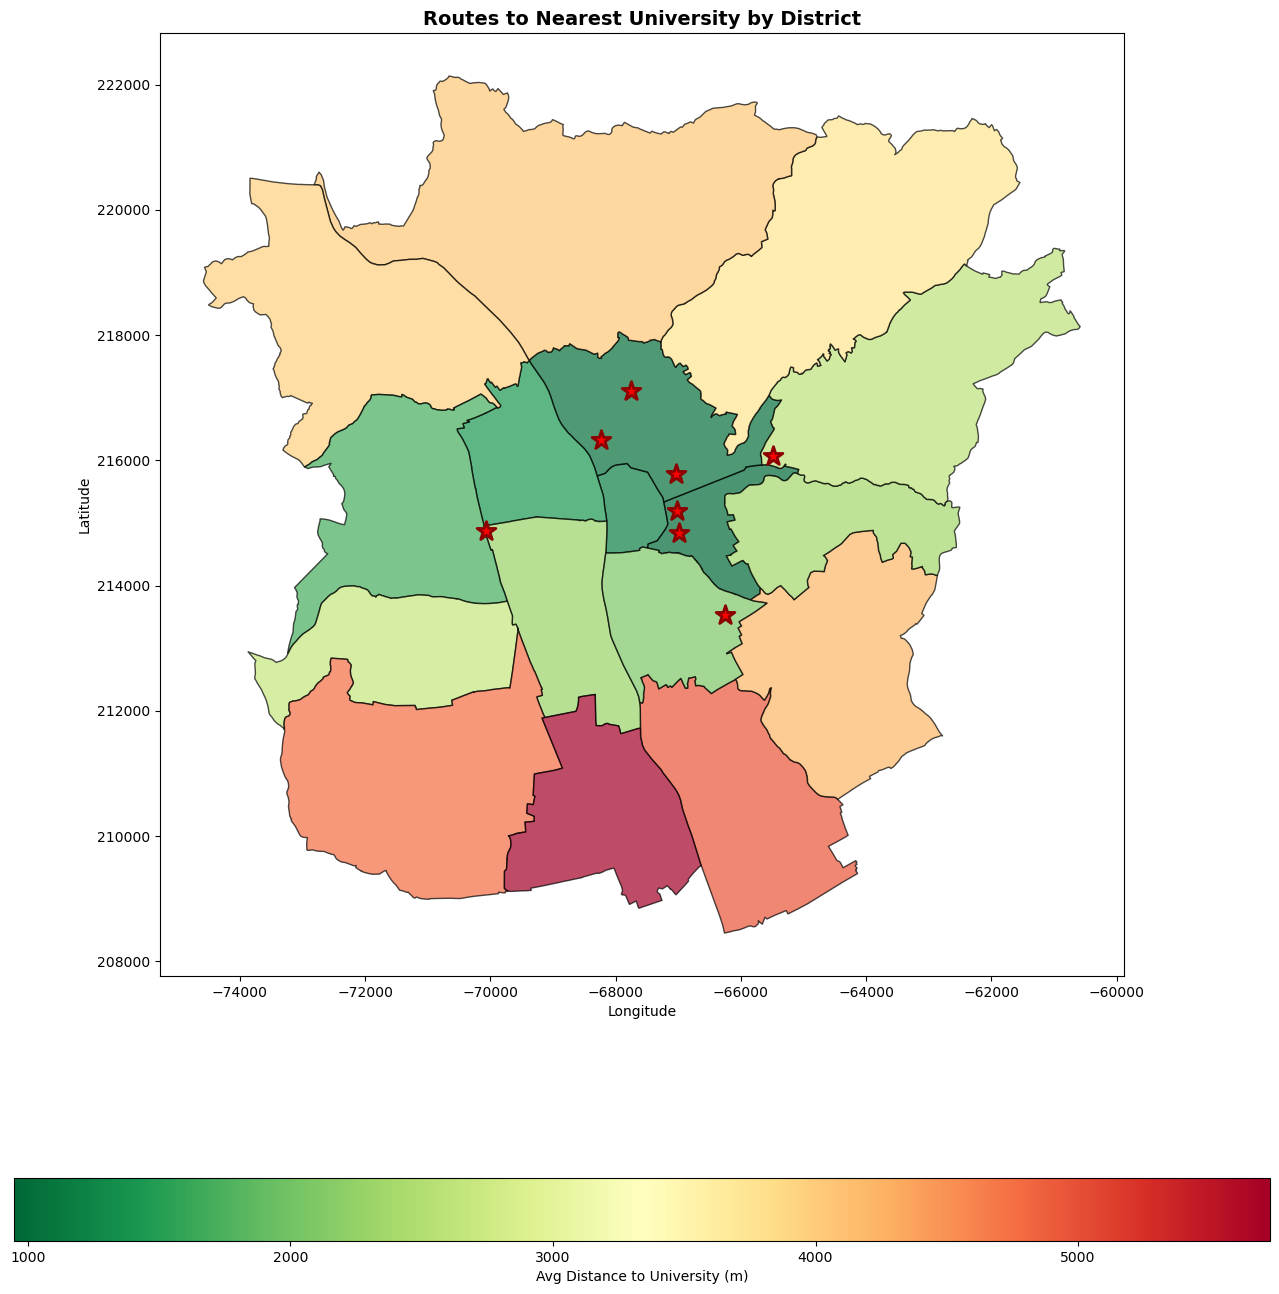

In [26]:
# Visualization 2: Map of routes by district
fig, ax = plt.subplots(figsize=(16, 14))

# Plot districts with color gradient based on average distance
df_districts_with_stats = df_districts.copy()
df_districts_with_stats['avg_distance'] = df_districts_with_stats['name'].map(
    lambda x: district_results.get(x, {}).get('avg_distance_m', 0)
)

df_districts_with_stats = df_districts_with_stats[df_districts_with_stats['avg_distance'] > 0]
df_districts_with_stats.plot(
    ax=ax,
    column='avg_distance',
    cmap='RdYlGn_r',
    edgecolor='black',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Distance to University (m)', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')


ax.set_title('Routes to Nearest University by District', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [27]:
# WEIGHTED ROUTING: Districts with custom cost function (speed, tramway, slope)
# Uses pre-computed distance maps from Setup cell
print("="*60)
print("WEIGHTED ROUTING ANALYSIS FOR DISTRICTS")
print("="*60)
print(f"Using {len(all_uni_node_ids)} universities for routing\n")

# Step 1: Process districts with weighted routing 
print("Processing districts with weighted costs...")
district_results_weighted = {}

for district in valid_districts:
    district_name = district["name"]
    print(f"Weighted routing for district: {district_name}")

    try:
        district_geom = district.geometry
        G_district = ox.truncate.truncate_graph_polygon(
            G_simple,
            district_geom,
            truncate_by_edge=True
        )

        nodes_in_district = list(G_district.nodes)
        
        if len(nodes_in_district) == 0:
            print(f"  No nodes in district '{district_name}', skipping")
            continue

        print(f"  {len(nodes_in_district)} nodes in district")

        # Use pre-computed paths 
        routes_data = []
        costs = []

        for origin_node in nodes_in_district:
            result = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type='weighted_cost')
            
            if result:
                routes_data.append({
                    'origin_node': origin_node,
                    'uni_node': result['uni_node'],
                    'weighted_cost': result['cost'],
                    'path': result['path'],
                    'district': district_name
                })
                costs.append(result['cost'])

        if costs:
            print(f"  Successfully routed {len(routes_data)}/{len(nodes_in_district)} nodes (weighted)")
            district_results_weighted[district_name] = {
                'total_routes': len(routes_data),
                'avg_weighted_cost': np.mean(costs),
                'min_weighted_cost': np.min(costs),
                'max_weighted_cost': np.max(costs),
                'routes': routes_data
            }
    
    except Exception as e:
        print(f"  Error processing district '{district_name}': {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"Total districts processed (weighted): {len(district_results_weighted)}")
print(f"{'='*60}\n")


WEIGHTED ROUTING ANALYSIS FOR DISTRICTS
Using 8 universities for routing

Processing districts with weighted costs...
Weighted routing for district: Innere Stadt
  762 nodes in district
  Successfully routed 616/762 nodes (weighted)
Weighted routing for district: Liebenau
  1507 nodes in district
  Successfully routed 1349/1507 nodes (weighted)
Weighted routing for district: Sankt Leonhard
  1047 nodes in district
  Successfully routed 1005/1047 nodes (weighted)
Weighted routing for district: Geidorf
  1866 nodes in district
  Successfully routed 1783/1866 nodes (weighted)
Weighted routing for district: Lend
  1404 nodes in district
  Successfully routed 1352/1404 nodes (weighted)
Weighted routing for district: Gries
  1762 nodes in district
  Successfully routed 1596/1762 nodes (weighted)
Weighted routing for district: Jakomini
  1472 nodes in district
  Successfully routed 1431/1472 nodes (weighted)
Weighted routing for district: Sankt Peter
  1738 nodes in district
  Successfully ro


Creating weighted routing map visualization...


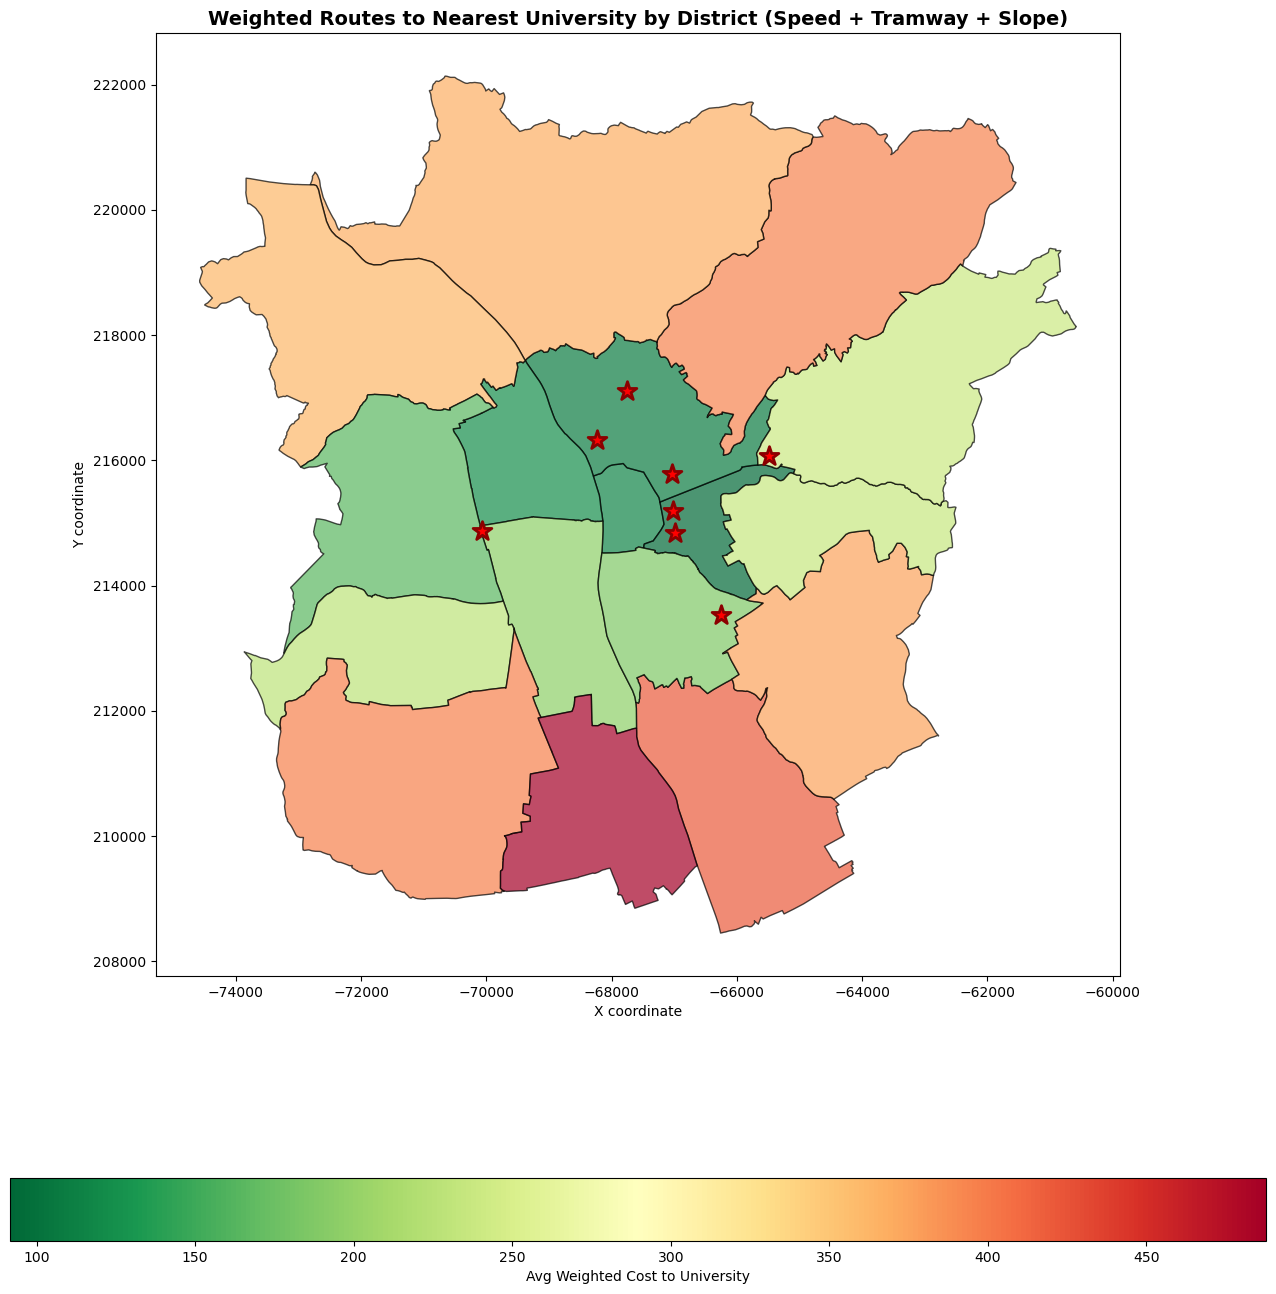

In [28]:
# Visualization 3: Map of weighted routes by district
print("\nCreating weighted routing map visualization...")
fig, ax = plt.subplots(figsize=(16, 14))

# Plot districts with color gradient based on WEIGHTED COST
df_districts_weighted_stats = df_districts.copy()
df_districts_weighted_stats['avg_weighted_cost'] = df_districts_weighted_stats['name'].map(
    lambda x: district_results_weighted.get(x, {}).get('avg_weighted_cost', 0)
)

df_districts_weighted_stats = df_districts_weighted_stats[df_districts_weighted_stats['avg_weighted_cost'] > 0]
df_districts_weighted_stats.plot(
    ax=ax,
    column='avg_weighted_cost',
    cmap='RdYlGn_r',
    edgecolor='black',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Avg Weighted Cost to University', 'orientation': 'horizontal', 'shrink': 0.8}
)

# Plot universities
graz_unis_snapped.plot(ax=ax, color='red', markersize=200, marker='*', 
                       edgecolor='darkred', linewidth=2, label='Universities')

ax.set_title('Weighted Routes to Nearest University by District (Speed + Tramway + Slope)', fontsize=14, fontweight='bold')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.tight_layout()
plt.show()



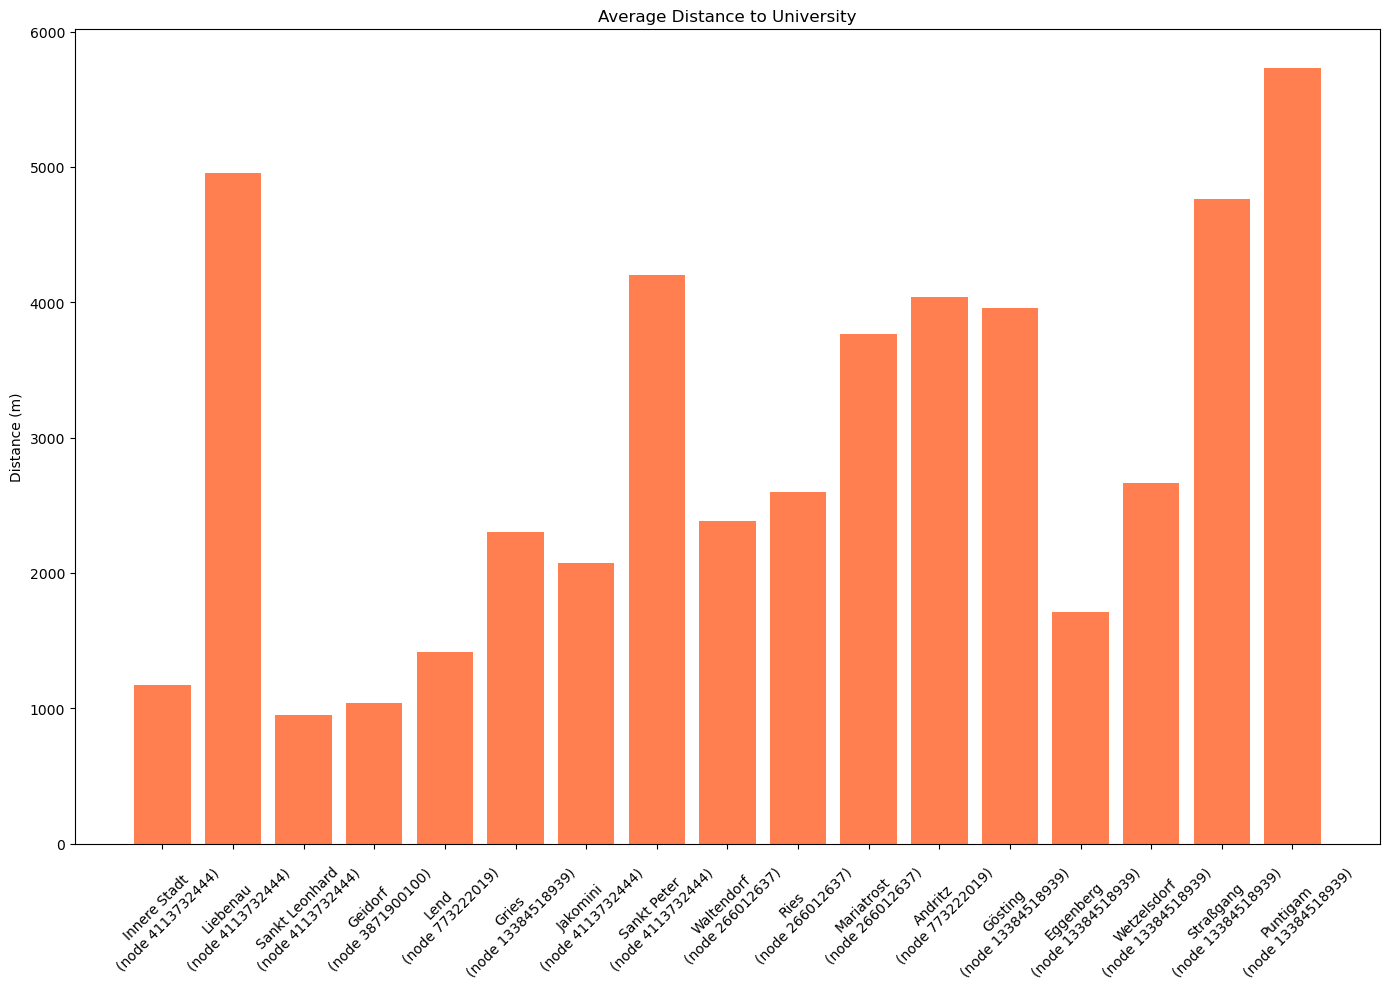

In [36]:
# Visualization 1: Bar charts for district statistics
fig, axes = plt.subplots(figsize=(14, 10))

summary_df["nearest_node"] = summary_df["District"].map(
    lambda d: max(set([r["uni_node"] for r in district_results[d]["routes"]]),
                  key=[r["uni_node"] for r in district_results[d]["routes"]].count)
)

labels = summary_df['District'] + "\n(node " + summary_df["nearest_node"].astype(str) + ")"

plt.bar(labels, summary_df['Avg Distance (m)'], color='coral')
plt.title('Average Distance to University')
plt.ylabel('Distance (m)')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [35]:
print(summary_df.columns.tolist())
print(summary_df.head())


['District', 'Total Routes', 'Avg Distance (m)', 'Min Distance (m)', 'Max Distance (m)']
         District  Total Routes  Avg Distance (m)  Min Distance (m)  \
0    Innere Stadt           616       1174.467978        416.137102   
1        Liebenau          1349       4955.258790       2890.167236   
2  Sankt Leonhard          1005        947.302361          0.000000   
3         Geidorf          1783       1038.026538          0.000000   
4            Lend          1352       1414.774144         96.991960   

   Max Distance (m)  
0       2087.043828  
1       7699.265482  
2       2359.539995  
3       2494.548865  
4       2928.798827  
